In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import linregress
from scipy.stats.mstats import winsorize
import plotly.express as px
import pandas as pd


## <u>Carga de datos</u>

In [170]:
df=pd.read_csv("ofertas_relampago.csv")

In [172]:
df.head()

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,OFFER_TYPE,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,ORIGIN,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,lightning_deal,4,-2,4.72,6.0,A,none,PETS FOOD,CPG,MLM-BIRD_FOODS
1,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 19:00:02+00:00,lightning_deal,5,5,NaN,NaN,NaN,free_shipping,PET PRODUCTS,OTHERS,MLM-ANIMAL_AND_PET_PRODUCTS
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,lightning_deal,15,12,10.73,3.0,NaN,none,COMPUTERS,CE,MLM-SPEAKERS
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,lightning_deal,15,13,7.03,2.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,lightning_deal,15,0,39.65,15.0,NaN,none,COMPUTERS,CE,MLM-HEADPHONES


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48746 entries, 0 to 48745
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OFFER_START_DATE           48746 non-null  object 
 1   OFFER_START_DTTM           48746 non-null  object 
 2   OFFER_FINISH_DTTM          48746 non-null  object 
 3   OFFER_TYPE                 48746 non-null  object 
 4   INVOLVED_STOCK             48746 non-null  int64  
 5   REMAINING_STOCK_AFTER_END  48746 non-null  int64  
 6   SOLD_AMOUNT                24579 non-null  float64
 7   SOLD_QUANTITY              24579 non-null  float64
 8   ORIGIN                     11316 non-null  object 
 9   SHIPPING_PAYMENT_TYPE      48746 non-null  object 
 10  DOM_DOMAIN_AGG1            48746 non-null  object 
 11  VERTICAL                   48746 non-null  object 
 12  DOMAIN_ID                  48746 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usag

#### Nos aseguramos de que las variables con fecha esten con el data type apropiado

In [179]:
df["start_date"] = pd.to_datetime(df["OFFER_START_DATE"])
df["OFFER_FINISH_DTTM"]=pd.to_datetime(df["OFFER_FINISH_DTTM"])
df["OFFER_START_DTTM"]=pd.to_datetime(df["OFFER_START_DTTM"])


#### Ver si hay columnas que tengan un solo valor. Si hay las eliminamos ya que no aportan información relevante para este análisis

In [181]:
df.apply(lambda col: col.nunique() == 1)

OFFER_START_DATE             False
OFFER_START_DTTM             False
OFFER_FINISH_DTTM            False
OFFER_TYPE                    True
INVOLVED_STOCK               False
REMAINING_STOCK_AFTER_END    False
SOLD_AMOUNT                  False
SOLD_QUANTITY                False
ORIGIN                        True
SHIPPING_PAYMENT_TYPE        False
DOM_DOMAIN_AGG1              False
VERTICAL                     False
DOMAIN_ID                    False
start_date                   False
dtype: bool

In [183]:
#Sacar columnas porque es el mismo valor para todas las observaciones
df=df.drop(columns=["OFFER_TYPE","ORIGIN"])

## <u>Estadísticas descriptivas y visualizaciones</u>

In [185]:
df.describe()

,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,start_date
count,48746.000000,48746.000000,24579.000000,24579.000000,48746
mean,35.007508,30.565216,51.208898,10.851052,2021-07-05 11:24:49.008328704
min,1.000000,-192.000000,0.280000,1.000000,2021-06-01 00:00:00
25%,5.000000,4.000000,5.730000,1.000000,2021-06-22 00:00:00
50%,10.000000,8.000000,12.420000,3.000000,2021-07-07 00:00:00
75%,15.000000,15.000000,30.925000,6.000000,2021-07-21 00:00:00
max,9000.000000,8635.000000,4836.570000,1646.000000,2021-07-31 00:00:00
std,206.761058,195.813806,175.254414,45.475305,NaN


#### Se supone que la cantidad vendida debería ser siempre igual al stock inicial-stock final, eso comprobaremos a continuación

In [187]:
condition = df["SOLD_QUANTITY"] == (df["INVOLVED_STOCK"] - df["REMAINING_STOCK_AFTER_END"])
count = condition.sum()
print("Cantidad de filas en las que no se cumple:", len(condition)-count)

Cantidad de filas en las que no se cumple: 27162


#### Hay muchas filas en las que no se cumple la condición

In [223]:
df.loc[~condition]

,OFFER_START_DATE,OFFER_START_DTTM,OFFER_FINISH_DTTM,INVOLVED_STOCK,REMAINING_STOCK_AFTER_END,SOLD_AMOUNT,SOLD_QUANTITY,SHIPPING_PAYMENT_TYPE,DOM_DOMAIN_AGG1,VERTICAL,DOMAIN_ID,start_date,duracion_oferta,cant_ventas_por_hora,val_ventas_por_hora,hora_inicio
0,2021-06-22,2021-06-22 16:00:00+00:00,2021-06-22 23:02:43+00:00,4,-2,4.72,6,none,PETS FOOD,CPG,MLM-BIRD_FOODS,2021-06-22,7,0.857143,0.674286,16
2,2021-06-22,2021-06-22 07:00:00+00:00,2021-06-22 13:00:01+00:00,15,12,10.73,3,none,COMPUTERS,CE,MLM-SPEAKERS,2021-06-22,6,0.500000,1.788333,7
3,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-23 01:36:12+00:00,15,13,7.03,2,none,COMPUTERS,CE,MLM-HEADPHONES,2021-06-22,7,0.285714,1.004286,19
4,2021-06-22,2021-06-22 13:00:00+00:00,2021-06-22 15:48:12+00:00,15,0,39.65,15,none,COMPUTERS,CE,MLM-HEADPHONES,2021-06-22,3,5.000000,13.216667,13
7,2021-06-22,2021-06-22 19:00:00+00:00,2021-06-22 23:05:39+00:00,10,-1,103.03,11,free_shipping,COMPUTERS,CE,MLM-HEADPHONES,2021-06-22,4,2.750000,25.757500,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48733,2021-06-19,2021-06-19 19:00:00+00:00,2021-06-20 01:00:02+00:00,5,4,6.98,1,free_shipping,AUTOPARTS,ACC,MLM-FOG_LIGHTS,2021-06-19,6,0.166667,1.163333,19
48737,2021-06-19,2021-06-19 15:00:00+00:00,2021-06-19 23:00:00+00:00,10,7,33.97,3,free_shipping,MOBILE,CE,MLM-TELEPHONES,2021-06-19,8,0.375000,4.246250,15
48741,2021-06-19,2021-06-19 13:00:00+00:00,2021-06-19 19:00:01+00:00,15,9,16.28,6,none,HOME&DECOR,HOME & INDUSTRY,MLM-CHRISTMAS_LIGHTS,2021-06-19,6,1.000000,2.713333,13
48743,2021-06-19,2021-06-19 07:00:00+00:00,2021-06-19 13:00:03+00:00,5,3,16.62,2,free_shipping,HOME&DECOR,HOME & INDUSTRY,MLM-INDOOR_CURTAINS_AND_BLINDS,2021-06-19,6,0.333333,2.770000,7


#### Lo ideal sería ver cual de las dos columnas presenta los datos correctos o más actualizados, por ahora vamos a suponer que las columnas de stock inicial y final son las que contienen los datos correctos y por lo tanto vamos a coercionar la columna SOLD_QUANTITY para que sea igual al stock inicial menos el stock final

In [201]:
df["SOLD_QUANTITY"] = df["INVOLVED_STOCK"] - df["REMAINING_STOCK_AFTER_END"]

#### Vemos que hay muchos valore NA en las columnas de cantidades y valores vendidos, y en el caso en que el stock inicial es igual al final, eso significa que hubo 0 ventas por lo que podemos rellenar esas columnas con 0 cuando se de esa condición.


In [203]:
condition = df["INVOLVED_STOCK"] == df["REMAINING_STOCK_AFTER_END"]
df.loc[condition, "SOLD_QUANTITY"] = 0
df.loc[condition, "SOLD_AMOUNT"] = 0

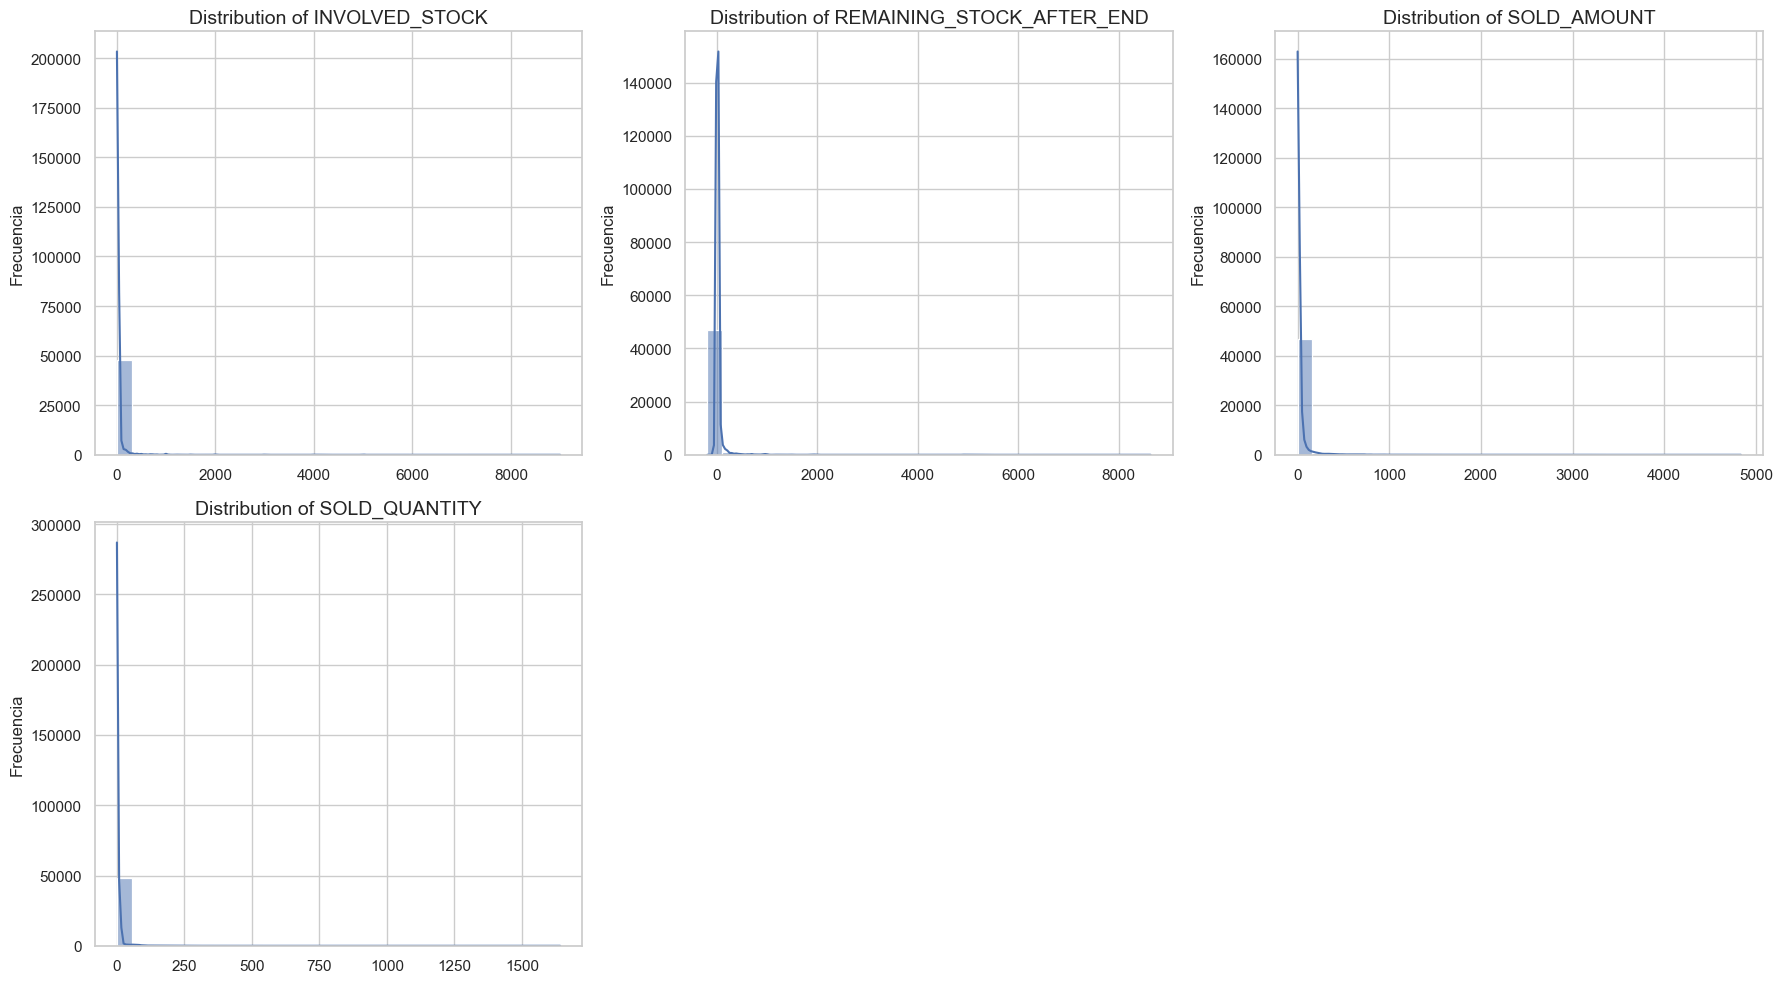

In [205]:
sns.set(style="whitegrid")

# Filtramos columnas numericas
numeric_cols = df.select_dtypes(include='number').columns

# Creamos graficos
n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols) 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia')

# Borramos graficos en blanco
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Como las distribuciones tienen valores extremos muy altos, vamos a winsorizar la serie al 95% para poder ver un poco mejor la distribución

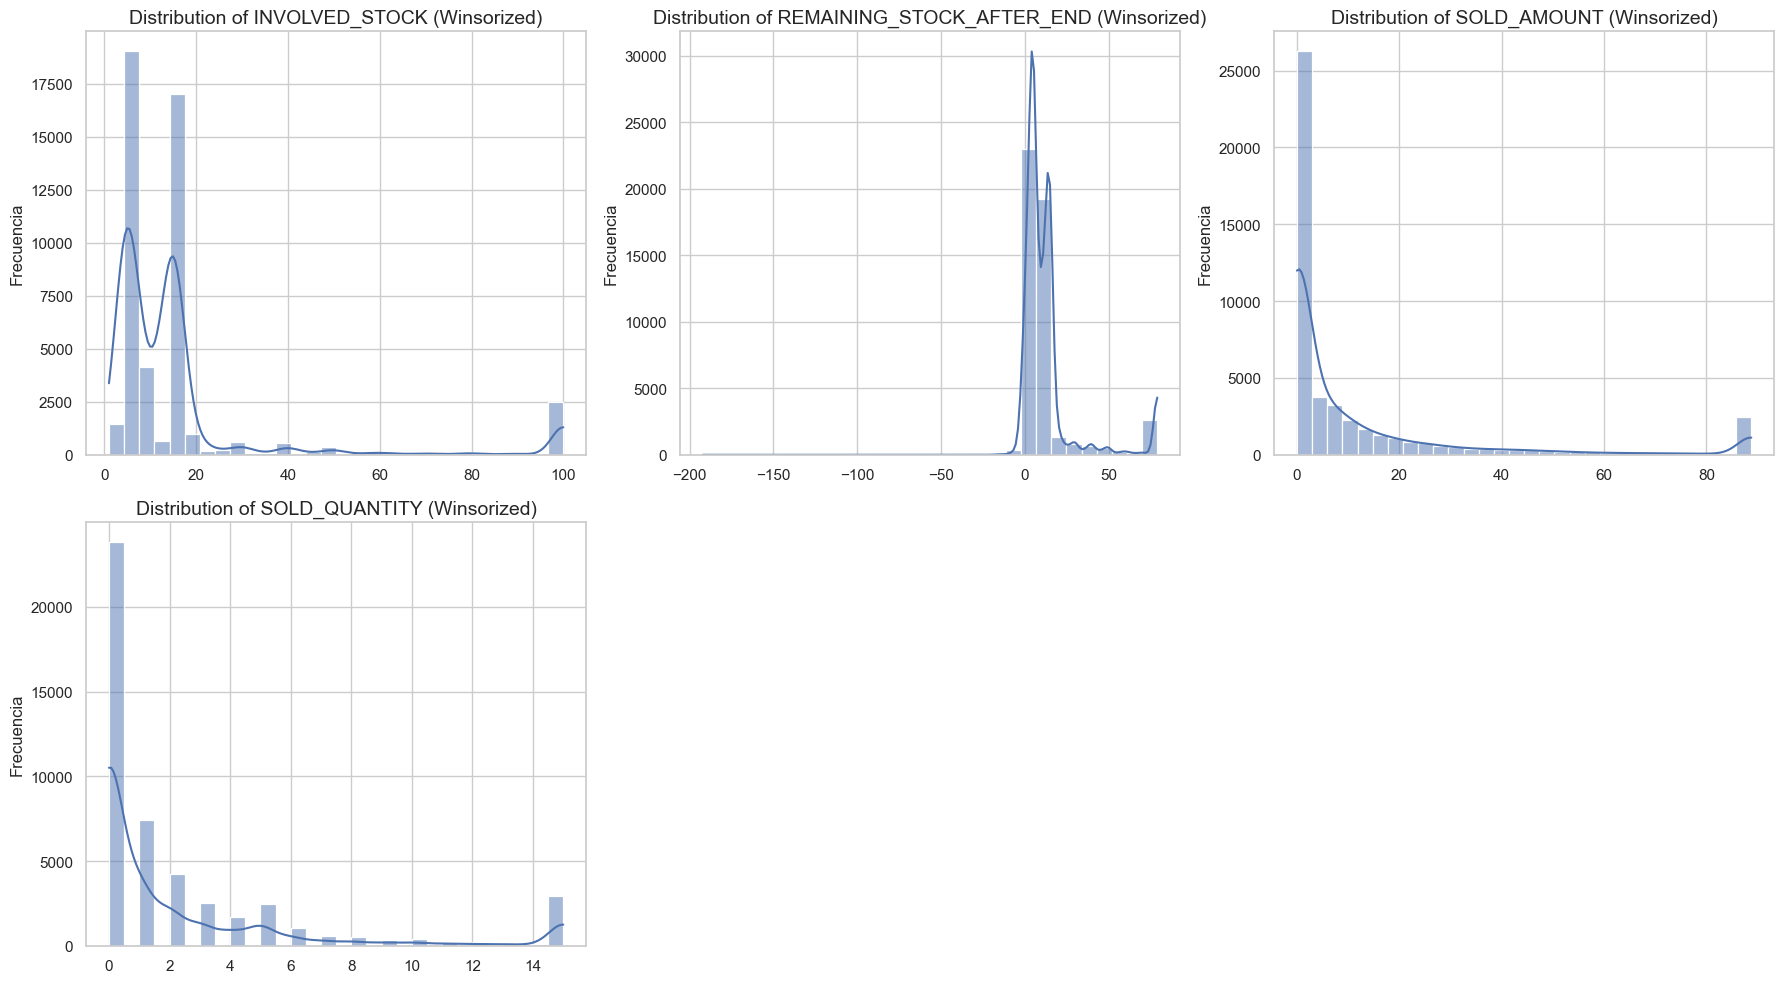

In [207]:
sns.set(style="whitegrid")

#Seleccionamos las columnas numericas
numeric_cols = df.select_dtypes(include='number').columns

# Creamos los espacios para los graficos
n_cols = 3
n_rows = -(-len(numeric_cols) // n_cols)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    #Winsorizamos las series al 95%
    dataw = winsorize(df[col].dropna(), limits=[0.0, 0.05])

    sns.histplot(dataw, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} (Winsorized)', fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia')

#Borramos graficos en blanco
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## <u>Ventas y duración de las ofertas</u>

#### Creamos la variable duracion_oferta

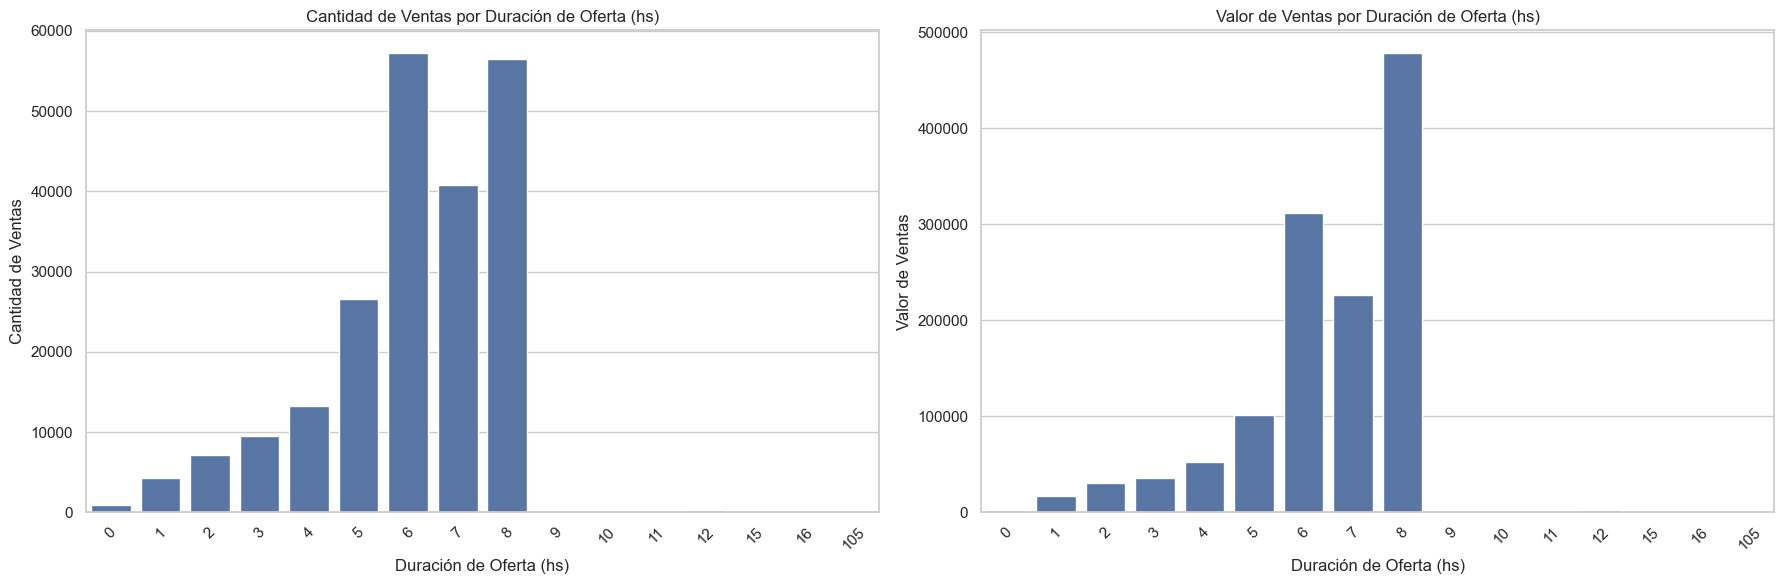

In [209]:
df["duracion_oferta"]=df["OFFER_FINISH_DTTM"]-df["OFFER_START_DTTM"]

# Redondeamos hacia la hora mas cercana
df['duracion_oferta'] = df['duracion_oferta'].dt.total_seconds() / 3600
df['duracion_oferta'] = df['duracion_oferta'].round().astype(int)

# Agrupamos las cantidades vendidas por la duracion de la oferta
sales_by_diff = df.groupby('duracion_oferta')['SOLD_QUANTITY'].sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#GRAFICO DE CANTIDADES
sns.barplot(data=sales_by_diff, x='duracion_oferta', y='SOLD_QUANTITY', ax=axes[0])
axes[0].set_title('Cantidad de Ventas por Duración de Oferta (hs)')
axes[0].set_xlabel('Duración de Oferta (hs)')
axes[0].set_ylabel('Cantidad de Ventas')
axes[0].tick_params(axis='x', rotation=45)

#GRAFICO DE VALORES
sales_by_diff = df.groupby('duracion_oferta')['SOLD_AMOUNT'].sum().reset_index()
sns.barplot(data=sales_by_diff, x='duracion_oferta', y='SOLD_AMOUNT', ax=axes[1])
axes[1].set_title('Valor de Ventas por Duración de Oferta (hs)')
axes[1].set_xlabel('Duración de Oferta (hs)')
axes[1].set_ylabel('Valor de Ventas')
axes[1].tick_params(axis='x', rotation=45)

# Layout
plt.tight_layout()
plt.show()

#### En base al grafico, podemos ver que la mayor cantidad y valor de ventas se dan en ofertas de 6 y 8 horas. Pero esto no significa necesariamente que ese tipo de ofertas a nivel individual sean las que más productos venden en comparación con otras, esto puede deberse simplemente a que haya mayor cantidad de ofertas de esa duración que de duraciones más cortas como 1-2 horas. Por lo tanto vamos a calcular el promedio de la cantidad y el valor de ventas para cada una de la duraciones de oferta.

#### También podemos ver que hay duraciones de 0 horas, por lo tanto vamos a eliminar filas en las que se de esa condición.

In [244]:
df = df[df["duracion_oferta"] != 0]

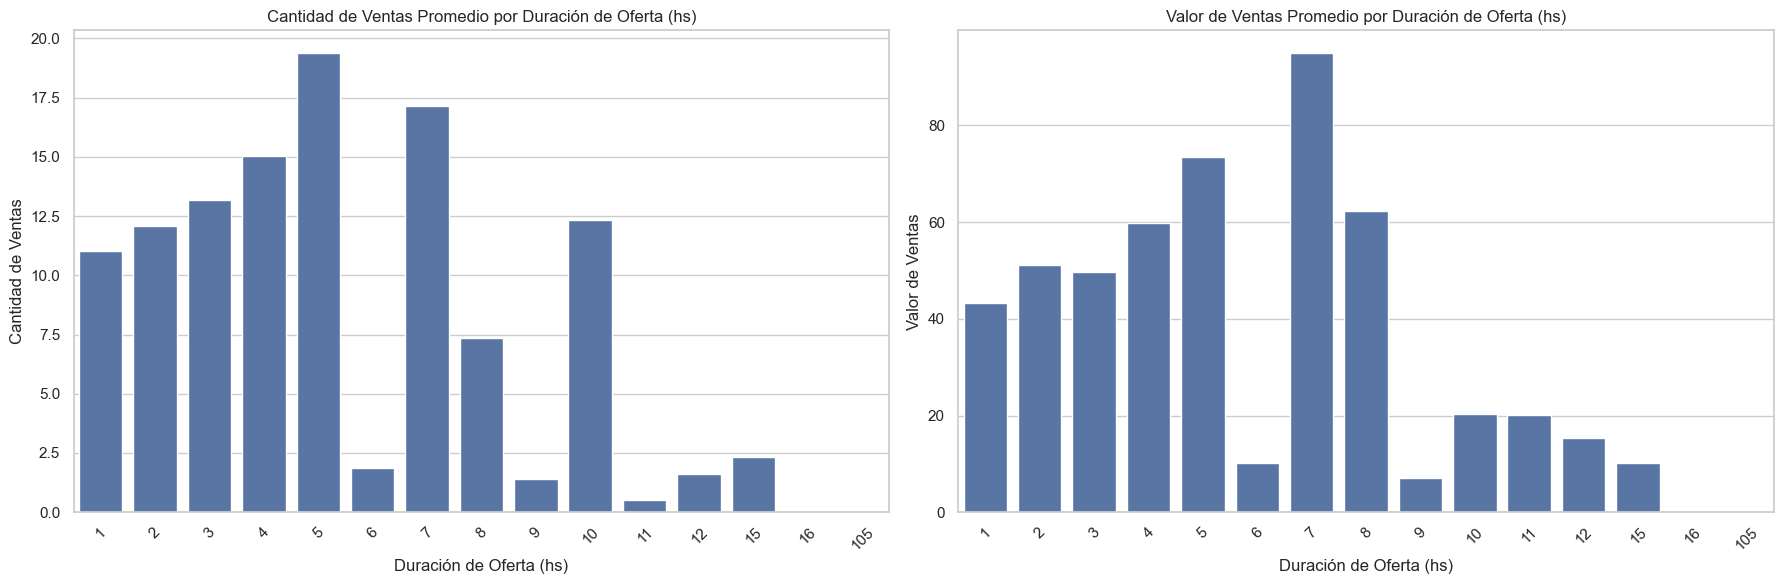

In [246]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#GRAFICO DE CANTIDADES
#Agrupamos las cantidades vendida por la duracion de la oferta
sales_sum = df.groupby('duracion_oferta')['SOLD_QUANTITY'].sum()
offer_counts = df.groupby('duracion_oferta').size()
# calculamos el promedio de cantidades vendidas por duracaion de oferta
sales_avg = (sales_sum / offer_counts).reset_index(name='avg_sales_per_offer')
sns.barplot(data=sales_avg, x='duracion_oferta', y='avg_sales_per_offer', ax=axes[0])
axes[0].set_title('Cantidad de Ventas Promedio por Duración de Oferta (hs)')
axes[0].set_xlabel('Duración de Oferta (hs)')
axes[0].set_ylabel('Cantidad de Ventas')
axes[0].tick_params(axis='x', rotation=45)

#GRAFICO DE VALORES
sales_sum = df.groupby('duracion_oferta')['SOLD_AMOUNT'].sum()
offer_counts = df.groupby('duracion_oferta').size()
sales_avg = (sales_sum / offer_counts).reset_index(name='avg_sales_per_offer')
sns.barplot(data=sales_avg, x='duracion_oferta', y='avg_sales_per_offer', ax=axes[1])
axes[1].set_title('Valor de Ventas Promedio por Duración de Oferta (hs)')
axes[1].set_xlabel('Duración de Oferta (hs)')
axes[1].set_ylabel('Valor de Ventas')
axes[1].tick_params(axis='x', rotation=45)

# Layout
plt.tight_layout()
plt.show()


#### Ajustando por cantidad de ofertas, vemos que las ofertas de 6 horas de duración muestran una significativa baja tanto en la cantidad como en el valor de las ventas en comparación con otras duraciones, esto puede deberse a factores como el horario en el que suelen iniciar esas ofertas (lo analizaremos más adelante). Para poder comparar mejor que tan eficaces son los distintos tipos de duraciones de ofertas al momento de vender mas, analizaremos las ventas promedio por hora de cada uno de los distintos tipos de duraciones de ofertas.

C:\Users\simon\AppData\Local\Temp\ipykernel_12228\4251615040.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cant_ventas_por_hora"]=df["SOLD_QUANTITY"]/df["duracion_oferta"]
C:\Users\simon\AppData\Local\Temp\ipykernel_12228\4251615040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["val_ventas_por_hora"]=df["SOLD_AMOUNT"]/df["duracion_oferta"]


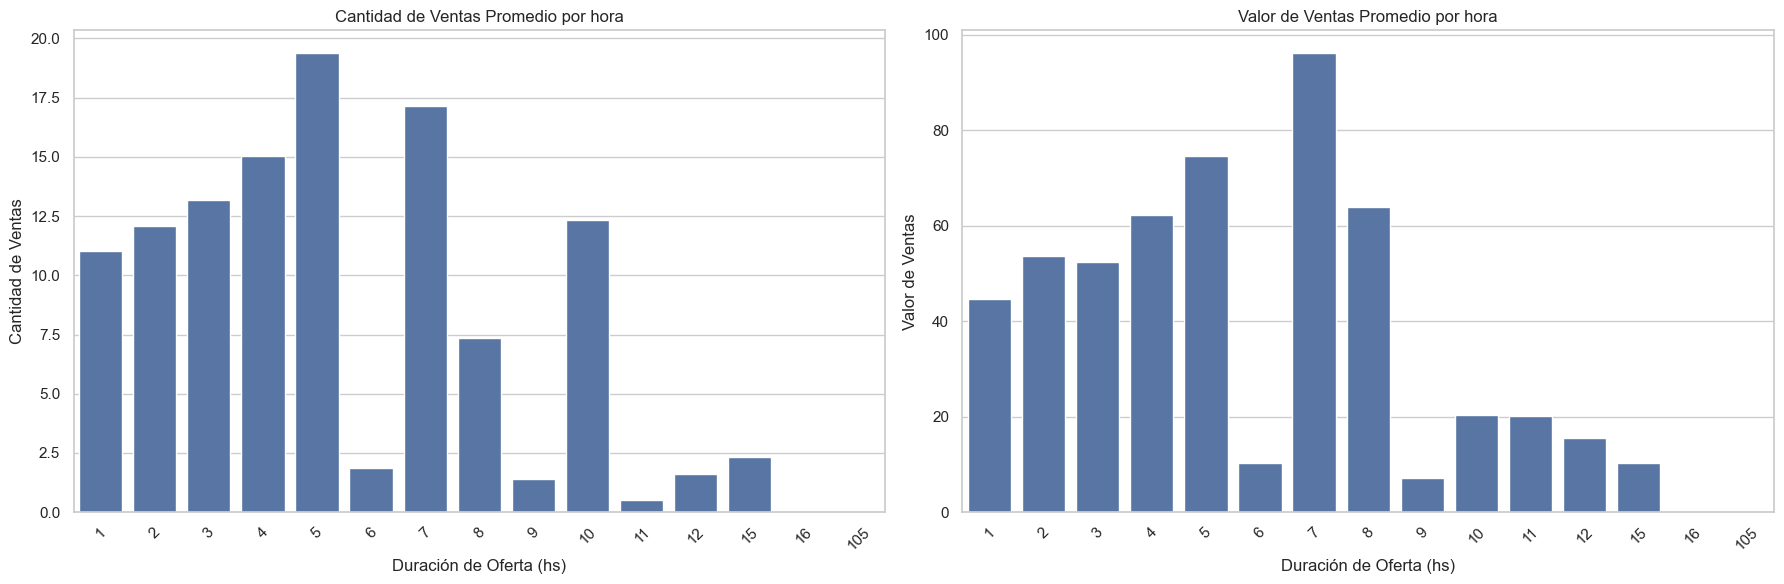

In [248]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#Creamos las variables de cantidades y valores de ventas por hora
df["cant_ventas_por_hora"]=df["SOLD_QUANTITY"]/df["duracion_oferta"]
df["val_ventas_por_hora"]=df["SOLD_AMOUNT"]/df["duracion_oferta"]



#GRAFICO DE CANTIDADES
sales_by_hour = df.groupby('duracion_oferta')['cant_ventas_por_hora'].mean().reset_index()
sales_by_hour["promedio_cantidad_vendida_total"]=sales_by_hour["duracion_oferta"]*sales_by_hour["cant_ventas_por_hora"]
sns.barplot(data=sales_by_hour, x='duracion_oferta', y='promedio_cantidad_vendida_total', ax=axes[0])
axes[0].set_title('Cantidad de Ventas Promedio por hora')
axes[0].set_xlabel('Duración de Oferta (hs)')
axes[0].set_ylabel('Cantidad de Ventas')
axes[0].tick_params(axis='x', rotation=45)

#GRAFICO DE VALORES
sales_by_hour = df.groupby('duracion_oferta')['val_ventas_por_hora'].mean().reset_index()
sales_by_hour["promedio_cantidad_vendida_total"]=sales_by_hour["duracion_oferta"]*sales_by_hour["val_ventas_por_hora"]
sns.barplot(data=sales_by_hour, x='duracion_oferta', y='promedio_cantidad_vendida_total', ax=axes[1])
axes[1].set_title('Valor de Ventas Promedio por hora')
axes[1].set_xlabel('Duración de Oferta (hs)')
axes[1].set_ylabel('Valor de Ventas')
axes[1].tick_params(axis='x', rotation=45)

# Layout
plt.tight_layout()
plt.show()


#### Podemos ver que las ofertas que en promedio por hora venden mas cantidad son aquellas que duran 5 horas y las de mayor valor vendido en promedio fueron las de 7 horas. Nuevamente vemos que las ofertas de 6 horas (a pesar de ser las segundas en cantidad de ventas y primeras en valor de ventas) tienen ventas mucho mas bajas que las ofertas de similares duraciones. Para poder analizar mejor este comportamiento debemos también tener en cuenta el horario de inicio de la oferta, eso analizaremos a continuación.

## <u>Análisis de ventas según la hora de inicio de la oferta</u>

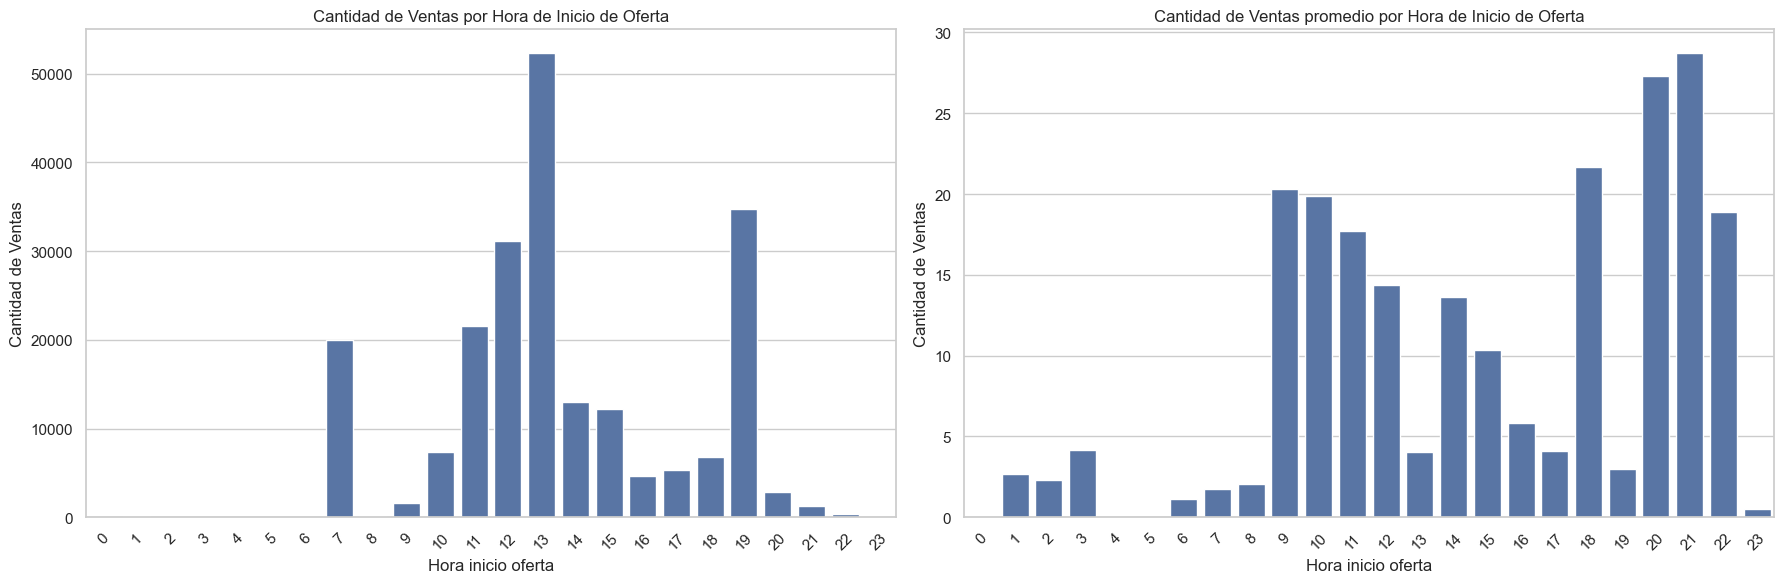

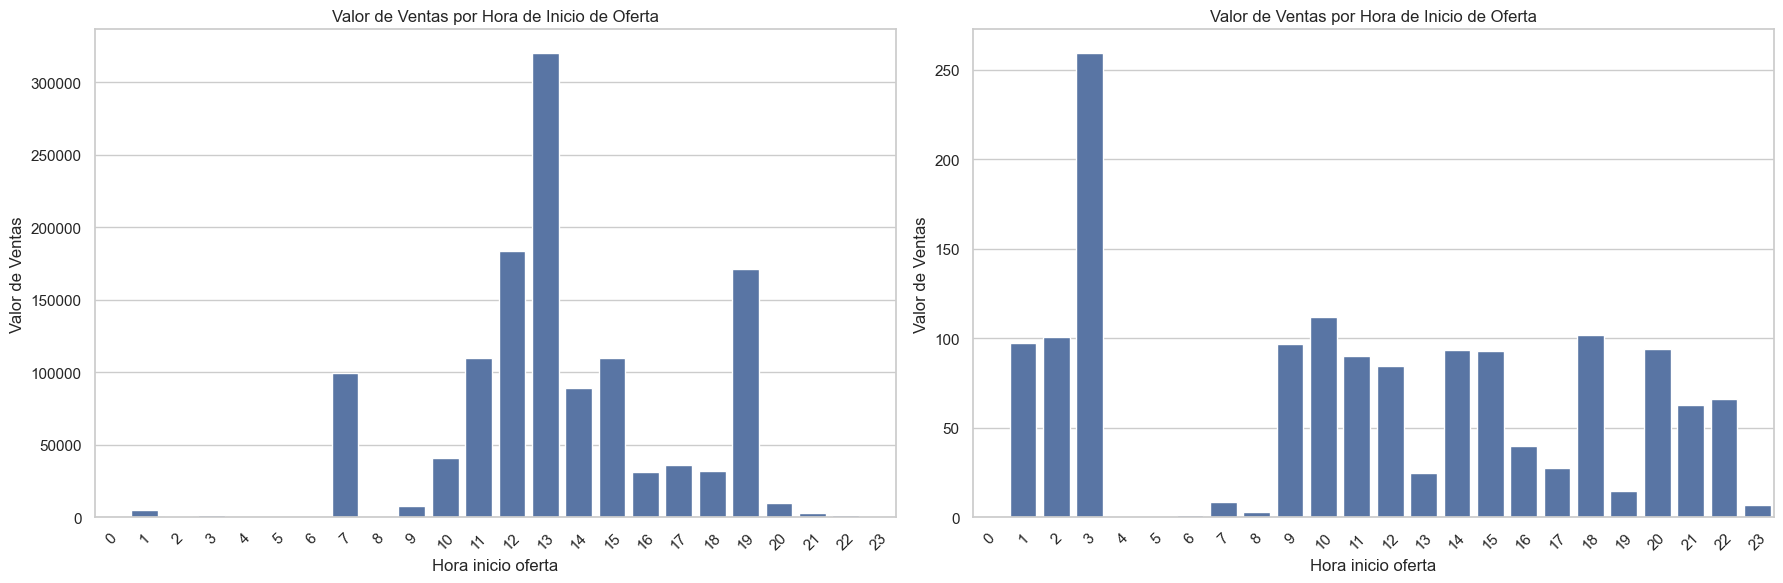

In [327]:
#Creamos la variable hora de inicio de la oferta
df["hora_inicio"]=df["OFFER_START_DTTM"].dt.hour

# Agrupamos la cantidad de ventas por hora de inicio
sales_by_diff = df.groupby('hora_inicio')['SOLD_QUANTITY'].sum().reset_index()
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=sales_by_diff, x='hora_inicio', y='SOLD_QUANTITY', ax=axes[0])
axes[0].set_title('Cantidad de Ventas por Hora de Inicio de Oferta')
axes[0].set_xlabel('Hora inicio oferta')
axes[0].set_ylabel('Cantidad de Ventas')
axes[0].tick_params(axis='x', rotation=45)
plt.tight_layout()
#Agregamos las cantidades vendidas en base a la hora de inicio de la oferta
sales_sum = df.groupby('hora_inicio')['SOLD_QUANTITY'].sum()
offer_counts = df.groupby('hora_inicio').size()
#Calculamos el promedio de ventas por hora de inicio
sales_avg = (sales_sum / offer_counts).reset_index(name='avg_sales_per_offer')
sns.barplot(data=sales_avg, x='hora_inicio', y='avg_sales_per_offer',  ax=axes[1])
axes[1].set_title('Cantidad de Ventas promedio por Hora de Inicio de Oferta')
axes[1].set_xlabel('Hora inicio oferta')
axes[1].set_ylabel('Cantidad de Ventas')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


# Agrupamos el valor de ventas por hora de inicio
sales_by_diff = df.groupby('hora_inicio')['SOLD_AMOUNT'].sum().reset_index()
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=sales_by_diff, x='hora_inicio', y='SOLD_AMOUNT', ax=axes[0])
axes[0].set_title('Valor de Ventas por Hora de Inicio de Oferta')
axes[0].set_xlabel('Hora inicio oferta')
axes[0].set_ylabel('Valor de Ventas')
axes[0].tick_params(axis='x', rotation=45)
plt.tight_layout()
#Agregamos los valores vendidos en base a la hora de inicio de la oferta
sales_sum = df.groupby('hora_inicio')['SOLD_AMOUNT'].sum()
offer_counts = df.groupby('hora_inicio').size()
#Calculamos el promedio de ventas por hora de inicio
sales_avg = (sales_sum / offer_counts).reset_index(name='avg_sales_per_offer')
sns.barplot(data=sales_avg, x='hora_inicio', y='avg_sales_per_offer',  ax=axes[1])
axes[1].set_title('Valor de Ventas por Hora de Inicio de Oferta')
axes[1].set_xlabel('Hora inicio oferta')
axes[1].set_ylabel('Valor de Ventas')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


#### Los gráficos de la izquierda nos muestran que las mayores cantidades y valor total vendido se dieron en ofertas que inician a las 7, 11-13 y 19. Eso puede deberse nuevamente a que haya gran número de ofertas que inicien en esos horarios. En cambio, en promedio (ajusta por el efecto de mayor número de ofertas) las mayores cantidades se vendieron en ofertas que empezaron a las 18, entre las 20 y 22, y entre las 9 y 12. Los mayores valores de venta promedio se dieron en las ofertas que empezaron a las 3 (esto puede ser afectado en gran medida por productos con precios altos). 

## <u>Relación entre ventas y la hora de inicio/duración de la oferta</u>

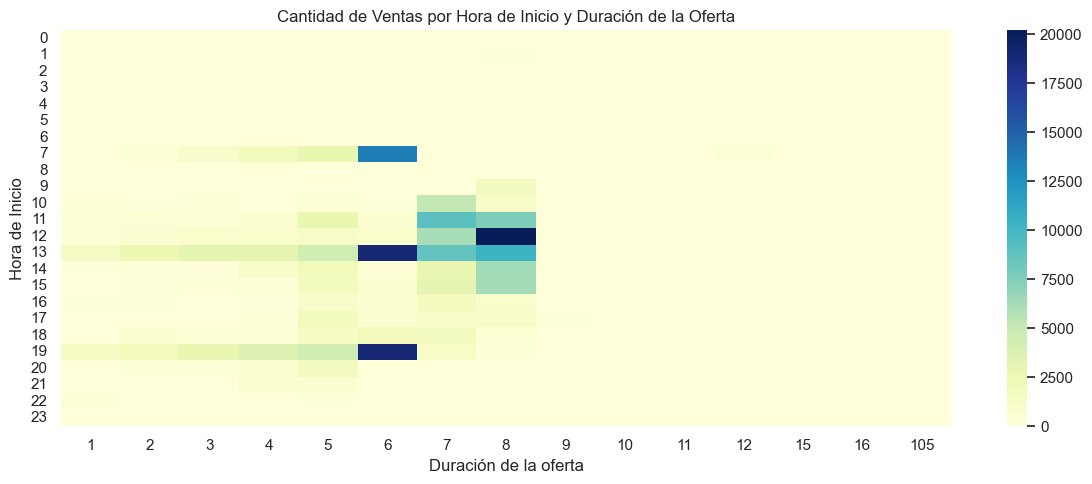

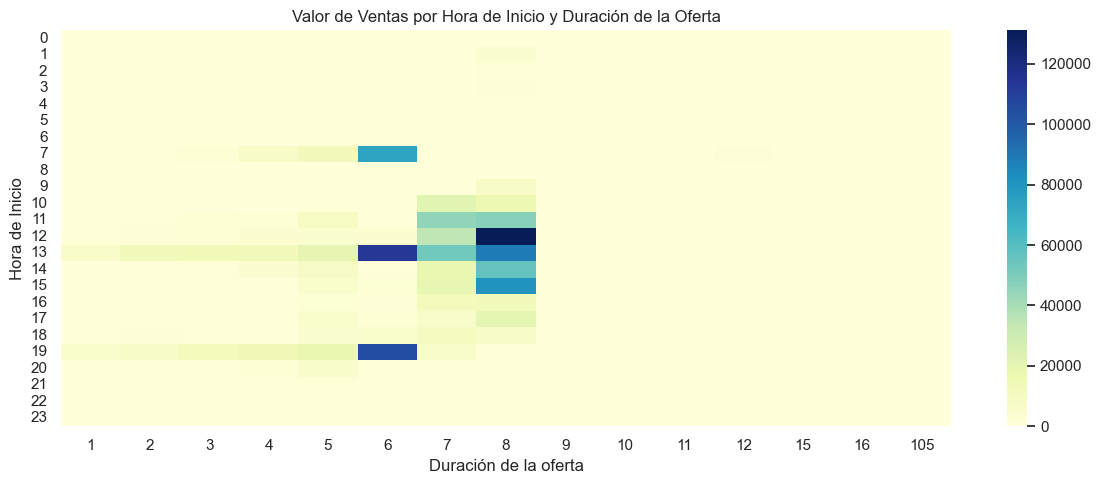

In [254]:
#Creamos una tabla dinamica con las variables hora de inicio, duracion de oferta y cantidad vendida
pivot = df.pivot_table(index='hora_inicio', columns='duracion_oferta', values='SOLD_QUANTITY', aggfunc='sum', fill_value=0)

plt.figure(figsize=(12, 5))
sns.heatmap(pivot, cmap='YlGnBu' ,annot=False,fmt=".0f")
plt.title('Cantidad de Ventas por Hora de Inicio y Duración de la Oferta')
plt.xlabel('Duración de la oferta')
plt.ylabel('Hora de Inicio')
plt.tight_layout()
plt.show()

pivot = df.pivot_table(index='hora_inicio', columns='duracion_oferta', values='SOLD_AMOUNT', aggfunc='sum', fill_value=0)

plt.figure(figsize=(12, 5))
sns.heatmap(pivot, cmap='YlGnBu' ,annot=False,fmt=".0f")
plt.title('Valor de Ventas por Hora de Inicio y Duración de la Oferta')
plt.xlabel('Duración de la oferta')
plt.ylabel('Hora de Inicio')
plt.tight_layout()
plt.show()

#### Gran parte de las ventas se dan con productos en los cuales la duración de la oferta es de 7-8 horas e inician entre las 11 y 15. También podemos ver que para las ofertas de seis horas de duración, los horarios de inicio donde hay más ventas son las 7, 13 y 19 hs. Pero como vimos antes, la cantidad de ofertas que hay para cada uno de estos intervalos afecta significativamente la cantidad de ventas en ellos, por lo tanto a continuación vamos a ajustar los valores en base a la cantidad de ofertas tomando el promedio vendido para cada intervalo.

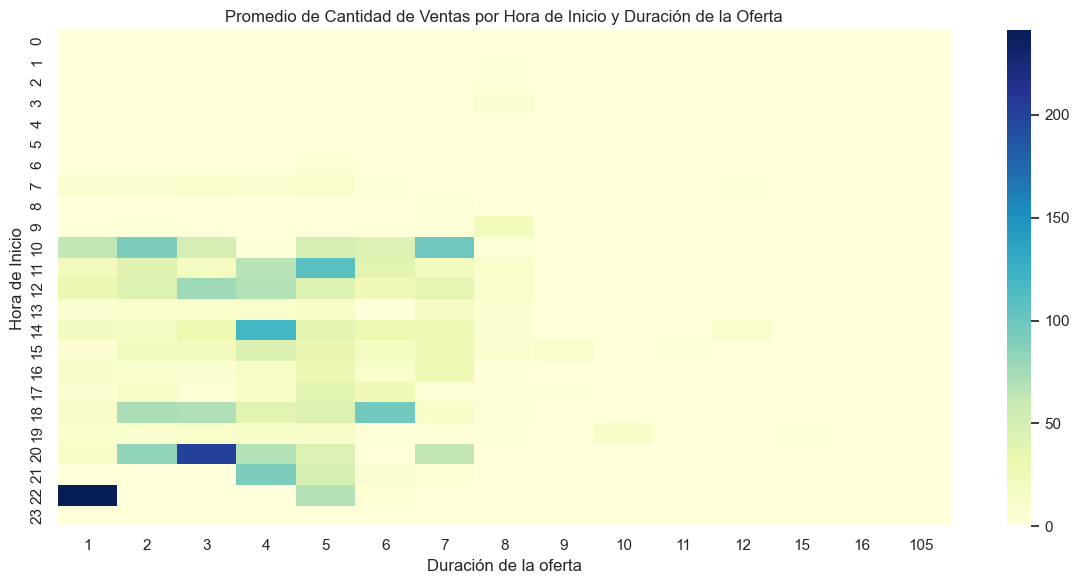

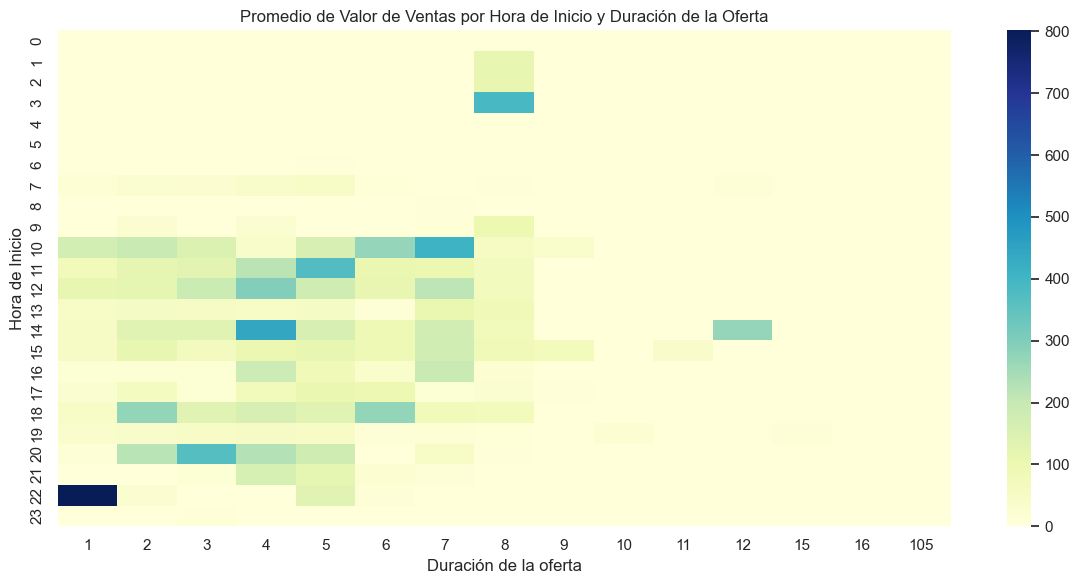

In [256]:
df["hora_inicio"] = df["OFFER_START_DTTM"].dt.hour
#Creamos tabla dinamica tomando la media en vez de la suma
pivot_avg = df.pivot_table(
    index='hora_inicio',
    columns='duracion_oferta',
    values='SOLD_QUANTITY',
    aggfunc='mean', 
    fill_value=0
)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_avg, cmap='YlGnBu', annot=False, fmt=".0f")  # Add values for clarity
plt.title('Promedio de Cantidad de Ventas por Hora de Inicio y Duración de la Oferta')
plt.xlabel('Duración de la oferta')
plt.ylabel('Hora de Inicio')
plt.tight_layout()
plt.show()

#Creamos tabla dinamica tomando la media en vez de la suma
pivot_avg = df.pivot_table(
    index='hora_inicio',
    columns='duracion_oferta',
    values='SOLD_AMOUNT',
    aggfunc='mean', 
    fill_value=0
)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_avg, cmap='YlGnBu', annot=False, fmt=".0f")  # Add values for clarity
plt.title('Promedio de Valor de Ventas por Hora de Inicio y Duración de la Oferta')
plt.xlabel('Duración de la oferta')
plt.ylabel('Hora de Inicio')
plt.tight_layout()
plt.show()

#### El mapa de calor nos muestra que las ofertas que más cantidad venden en promedio son aquellas que empiezan a las 22 y duran tan solo una hora seguidas por las que empiezan a las 20 y duran 3 horas. En cuanto al valor de las ventas, se repite lo mismo, pero también vemos que aparece un cluster de ofertas que inician a las 3am y duran 8 horas y que presentan en promedio un alto valor de ventas.

## <u>Análisis de Ventas a lo largo del tiempo</u>

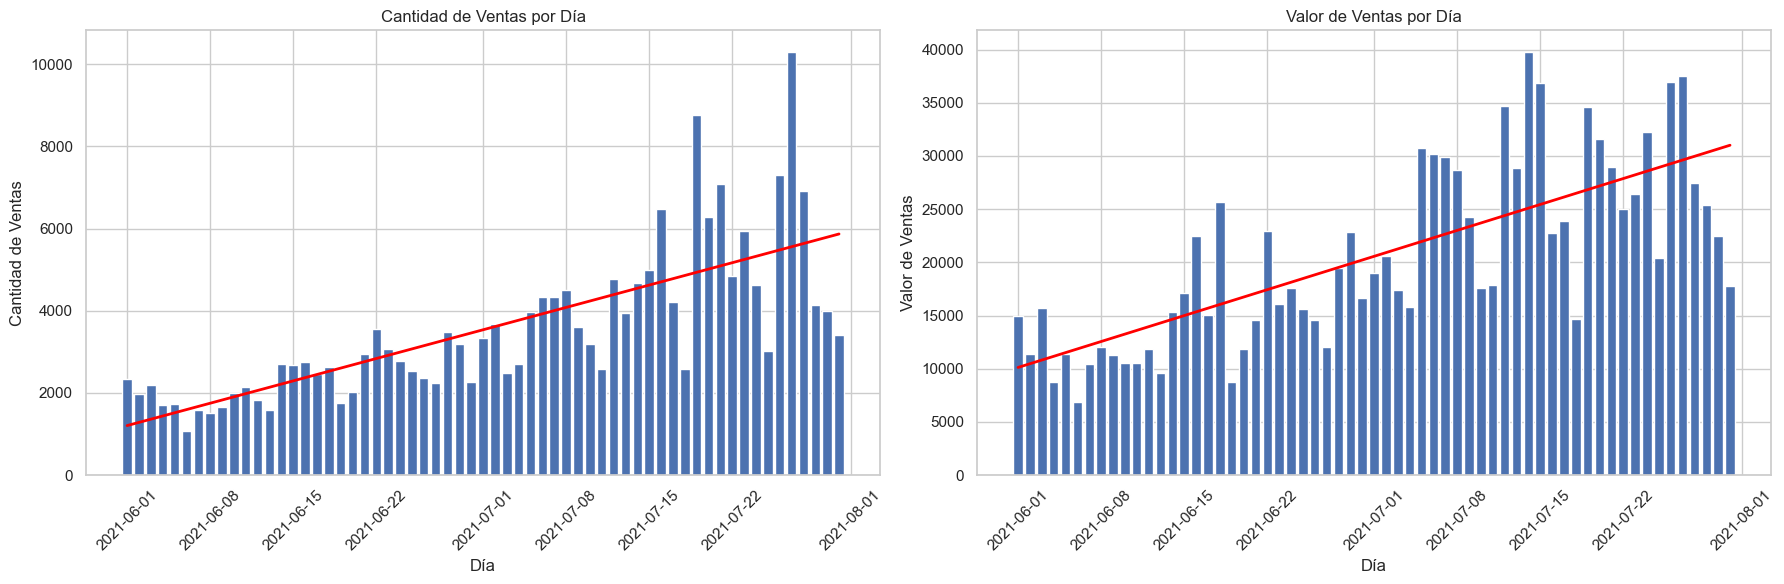

In [261]:
## Gráfico de cantidades vendidas por dia
sales_by_date = df.groupby("start_date")["SOLD_QUANTITY"].sum().reset_index()
sales_by_date = sales_by_date.sort_values('start_date')
# Convertimos fechas a valores numericos para la regresion
x = mdates.date2num(sales_by_date['start_date'])
y = sales_by_date['SOLD_QUANTITY']
# hacemos una regresion linear para agregar la linea de tendencia
slope, intercept, r_value, p_value, std_err = linregress(x, y)
trend_line = slope * x + intercept

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].bar(sales_by_date['start_date'], y, width=0.8, label='ventas diarias')
axes[0].plot(sales_by_date['start_date'], trend_line, color='red', linewidth=2, label='Trend Line (Linear Regression)')
axes[0].set_title('Cantidad de Ventas por Día')
axes[0].set_xlabel('Día')
axes[0].set_ylabel('Cantidad de Ventas')
axes[0].tick_params(axis='x', rotation=45)
plt.tight_layout()

## Gráfico de valores vendidos por dia

sales_by_date = df.groupby("start_date")["SOLD_AMOUNT"].sum().reset_index()
sales_by_date = sales_by_date.sort_values('start_date')
# Convertimos fechas a valores numericos para la regresion
x = mdates.date2num(sales_by_date['start_date'])
y = sales_by_date['SOLD_AMOUNT']
# hacemos una regresion linear para agregar la linea de tendencia
slope, intercept, r_value, p_value, std_err = linregress(x, y)
trend_line = slope * x + intercept
axes[1].bar(sales_by_date['start_date'], y, width=0.8, label='Ventas diarias')
axes[1].plot(sales_by_date['start_date'], trend_line, color='red', linewidth=2, label='Trend Line (Linear Regression)')
axes[1].set_title('Valor de Ventas por Día')
axes[1].set_xlabel('Día')
axes[1].set_ylabel('Valor de Ventas')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

#### Podemos ver mediante la línea de tendencia que la cantidad de ventas se incrementaron a lo largo de los días durante los dos meses de análisis. Esto puede deberse en parte a un aumento de la cantidad de ofertas hacia el final del período, para ver si ese es el caso vamos a primero ver el comportamiento de la cantidad de ofertas a lo largo de los días y luego repetiremos el mismo análisis por día pero ajustando las ventas por la cantidad de ofertas que hay en cada día

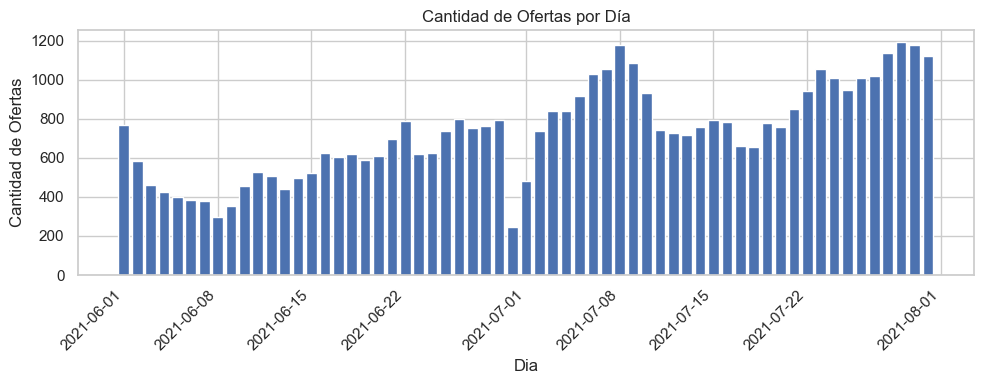

In [264]:
date_counts = df.groupby(df["start_date"].dt.date).size()
date_counts
plt.figure(figsize=(10, 4)) 
plt.bar(date_counts.index, date_counts.values)
plt.xlabel('Dia')
plt.ylabel('Cantidad de Ofertas')
plt.title('Cantidad de Ofertas por Día')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

### Efectivamente vemos que hay un aumento de la cantidad de ofertas a lo largo del tiempo lo que seguramente contribuye a un aumento de las ventas, para incluir este dato en el análisis a continuación ajustamos las ventas por la cantidad de ofertas de cada día

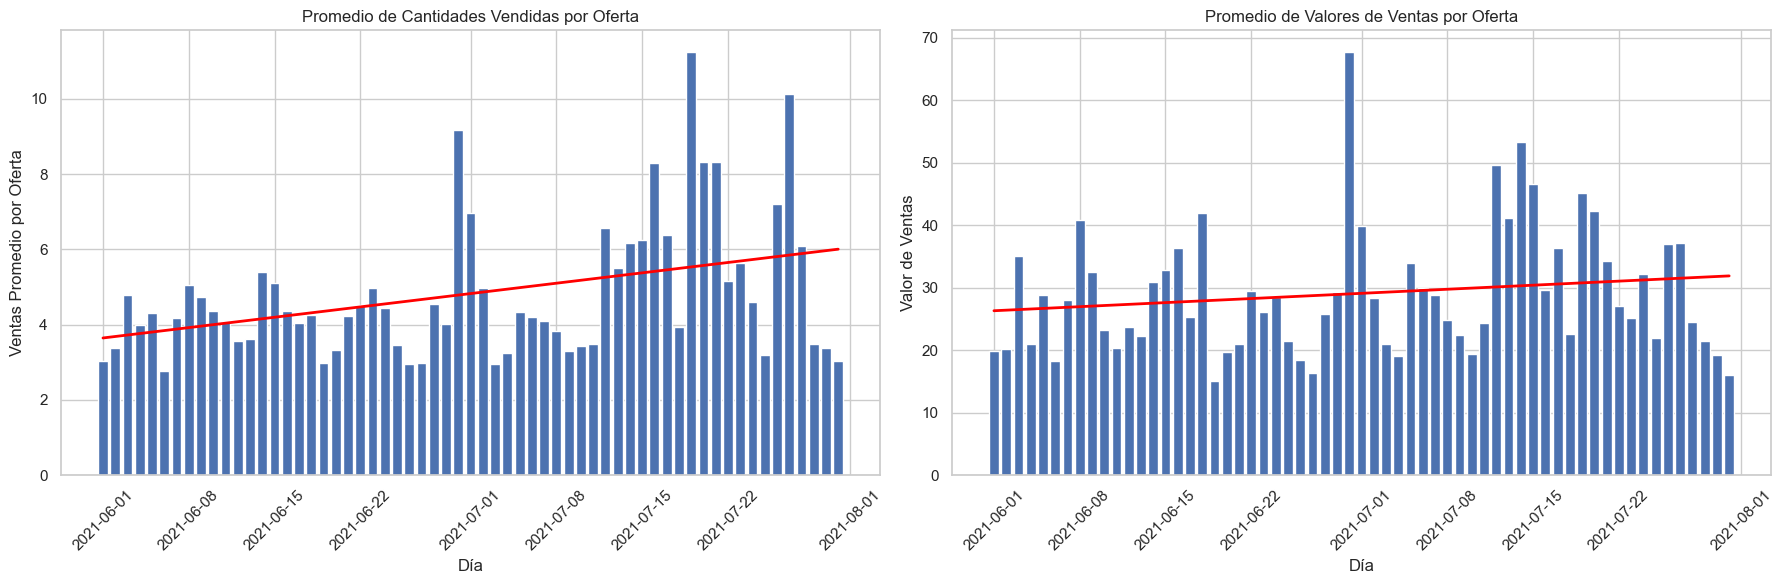

In [266]:
import matplotlib.dates as mdates
from scipy.stats import linregress
import matplotlib.pyplot as plt

#GRAFICO DE CANTIDADES

#Calculamos el valor de ventas promedio por día
sales_by_date = df.groupby('start_date').agg(
    total_sales=('SOLD_QUANTITY', 'sum'),
    num_offers=('SOLD_QUANTITY', 'count')
).reset_index()
sales_by_date['avg_sales_per_offer'] = sales_by_date['total_sales'] / sales_by_date['num_offers']
sales_by_date = sales_by_date.sort_values('start_date')
# hacemos una regresion linear para agregar la linea de tendencia
x = mdates.date2num(sales_by_date['start_date']) 
y = sales_by_date['avg_sales_per_offer']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
trend_line = slope * x + intercept

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].bar(sales_by_date['start_date'], y, width=0.8, label='Average Daily Sales per Offer')
axes[0].plot(sales_by_date['start_date'], trend_line, color='red', linewidth=2, label='Trend Line (Linear Regression)')
axes[0].set_title('Promedio de Cantidades Vendidas por Oferta')
axes[0].set_xlabel('Día')
axes[0].set_ylabel('Ventas Promedio por Oferta')
axes[0].tick_params(axis='x', rotation=45)
plt.tight_layout()

#GRAFICO DE VALORES DE VENTA

#Calculamos el valor de ventas promedio por día
sales_by_date = df.groupby('start_date').agg(
    total_sales=('SOLD_AMOUNT', 'sum'),
    num_offers=('SOLD_AMOUNT', 'count')
).reset_index()
sales_by_date['avg_sales_per_offer'] = sales_by_date['total_sales'] / sales_by_date['num_offers']
sales_by_date = sales_by_date.sort_values('start_date')
# hacemos una regresion linear para agregar la linea de tendencia
x = mdates.date2num(sales_by_date['start_date']) 
y = sales_by_date['avg_sales_per_offer']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
trend_line = slope * x + intercept

axes[1].bar(sales_by_date['start_date'], y, width=0.8, label='Average Daily Sales per Offer')
axes[1].plot(sales_by_date['start_date'], trend_line, color='red', linewidth=2, label='Trend Line (Linear Regression)')
axes[1].set_title('Promedio de Valores de Ventas por Oferta')
axes[1].set_xlabel('Día')
axes[1].set_ylabel('Valor de Ventas')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()




#### Vemos que ajustando por la cantidad de ofertas la tendencia se mantiene con pendiente positiva pero es menor, esto quiere decir que tanto la cantidad de ventas como el valor de las mismas aumentó durante este período más allá del aumento de la cantidad de ofertas.

## <u> Ventas promedio a lo largo de los días del mes</u>

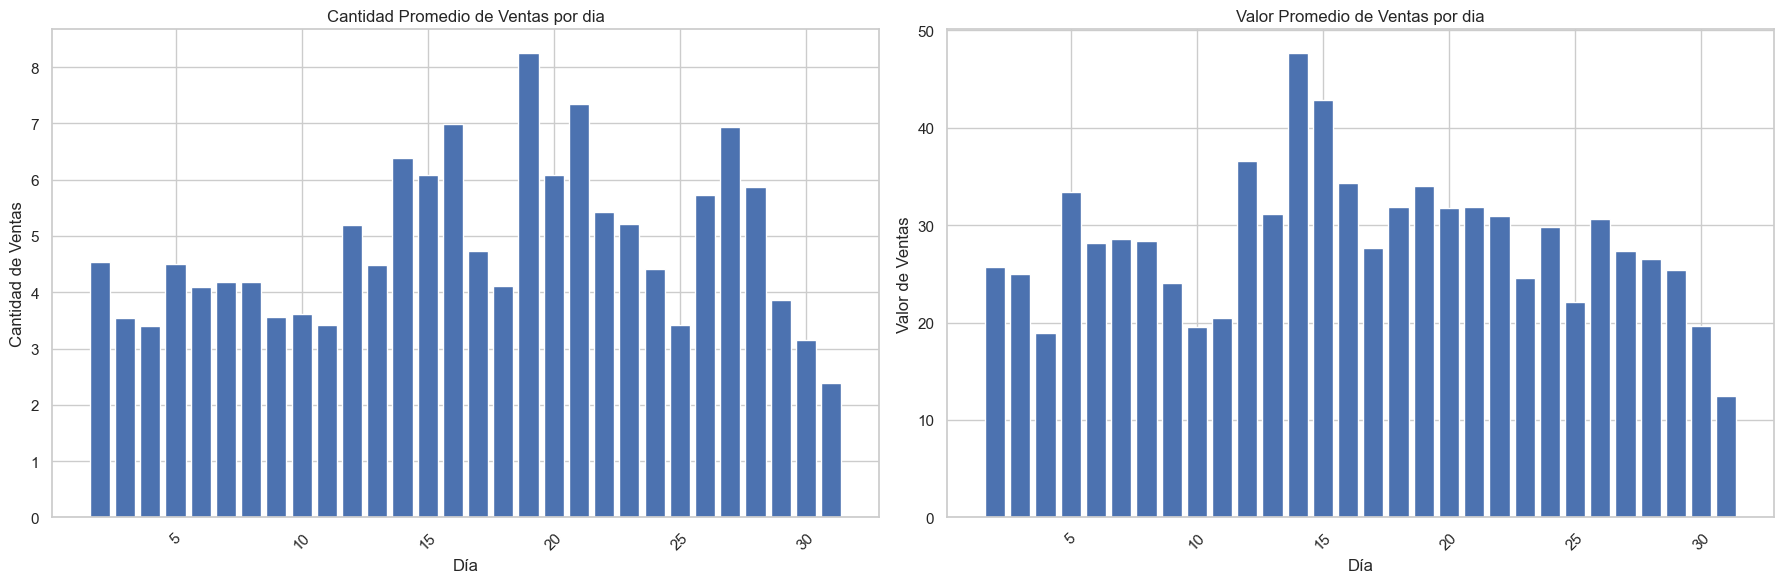

In [274]:
#Creamos las variables mes y dia de cada oferta
df['month'] = df['start_date'].dt.month
df['day'] = df['start_date'].dt.day

## GRAFICO DE CANTIDADES VENDIDAS
#Agrupamos las cantidades vendidas por dia 
sales_by_day = df.groupby('day')['SOLD_QUANTITY'].sum().reset_index()
offer_counts = df.groupby('day').size()
# Calculo de cantidades vendidas promedio por día
avg_sales_by_day = (sales_by_day["SOLD_QUANTITY"] / offer_counts)
sales_by_day["avg_sales_by_day"]=avg_sales_by_day


fig, axes = plt.subplots(1, 2, figsize=(18, 6))
axes[0].bar(sales_by_day['day'], sales_by_day['avg_sales_by_day'], width=0.8)
axes[0].set_title('Cantidad Promedio de Ventas por dia')
axes[0].set_xlabel('Día')
axes[0].set_ylabel('Cantidad de Ventas')
axes[0].tick_params(axis='x', rotation=45)
plt.tight_layout()

## GRAFICO DE VALORES VENDIDOS
#Agrupamos los valores vendidas por dia 
sales_by_day = df.groupby('day')['SOLD_AMOUNT'].sum().reset_index()
offer_counts = df.groupby('day').size()
# Calculo de cantidades vendidas promedio por día
avg_sales_by_day = (sales_by_day["SOLD_AMOUNT"] / offer_counts)
sales_by_day["avg_sales_by_day"]=avg_sales_by_day

axes[1].bar(sales_by_day['day'], sales_by_day['avg_sales_by_day'], width=0.8)
axes[1].set_title('Valor Promedio de Ventas por dia')
axes[1].set_xlabel('Día')
axes[1].set_ylabel('Valor de Ventas')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


#### Tanto la cantidad como el valor de las ventaspresentan altos valores a medidados de mes, teniendo las cantidades un pico hacia finales de mes.

## Análisis de ventas por día de la semana

C:\Users\simon\AppData\Local\Temp\ipykernel_12228\2087955644.py:22: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  sales_by_day['day'] = sales_by_day['day'].replace(weekday_trad)
C:\Users\simon\AppData\Local\Temp\ipykernel_12228\2087955644.py:38: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  sales_by_day['day'] = sales_by_day['day'].replace(weekday_trad)


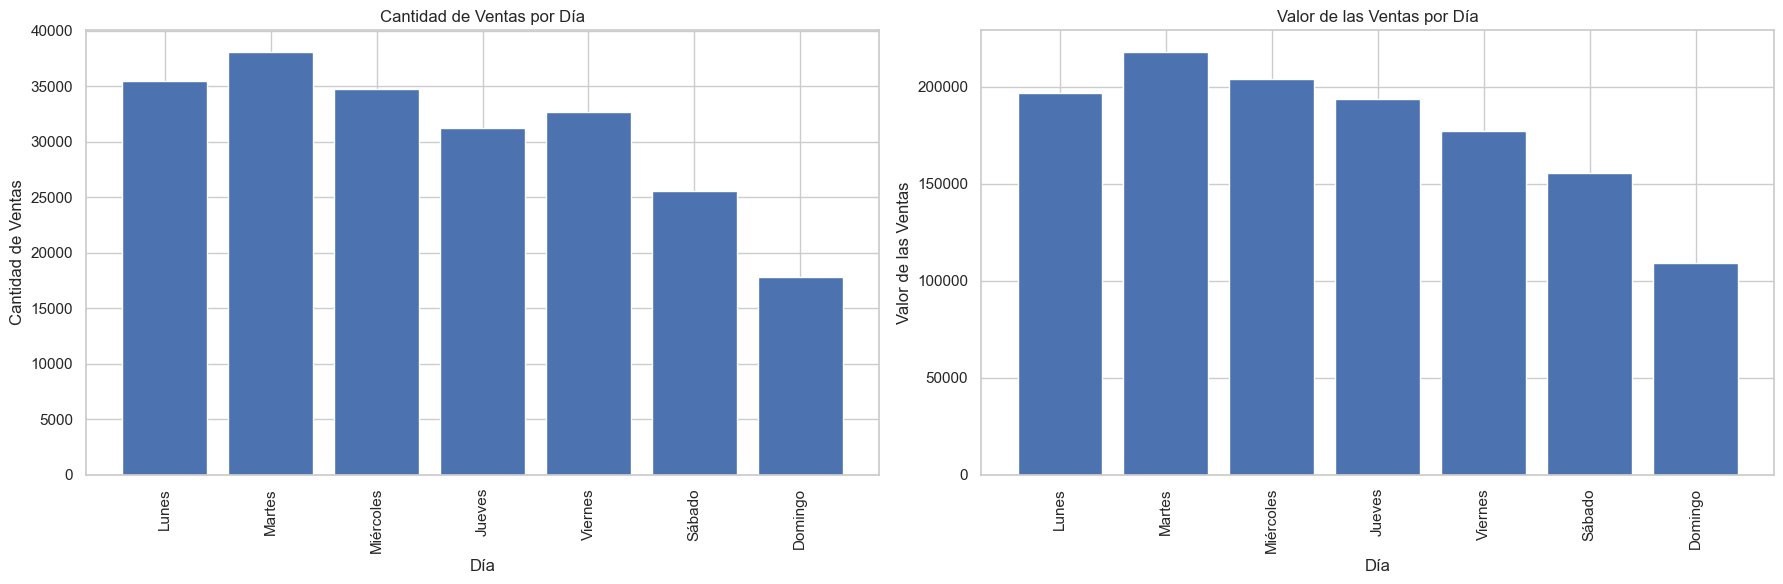

In [333]:
df['day'] = df['start_date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_trad = {
    'Monday': 'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miércoles',
    'Thursday': 'Jueves',
    'Friday': 'Viernes',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
}


## GRAFICO DE CANTIDADES VENDIDAS
#Agrupamos las cantidades vendidaas por dia de la semana
sales_by_day = df.groupby('day')['SOLD_QUANTITY'].sum().reset_index()
sales_by_day['day'] = pd.Categorical(sales_by_day['day'], categories=weekday_order, ordered=True)

# Ordenar por dia
sales_by_day = sales_by_day.sort_values('day')
#Traducir nombres de dias
sales_by_day['day'] = sales_by_day['day'].replace(weekday_trad)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns
axes[0].bar(sales_by_day['day'], sales_by_day['SOLD_QUANTITY'], width=0.8) 
axes[0].set_xlabel('Día')
axes[0].set_ylabel('Cantidad de Ventas')
axes[0].set_title('Cantidad de Ventas por Día')
axes[0].tick_params(axis='x', rotation=90)

## GRAFICO DE VALORES VENDIDOS
#Agrupamos los valores vendidos por dia de la semana
sales_by_day = df.groupby('day')['SOLD_AMOUNT'].sum().reset_index()
sales_by_day['day'] = pd.Categorical(sales_by_day['day'], categories=weekday_order, ordered=True)

# Ordenamos los datos por dia de la semana
sales_by_day = sales_by_day.sort_values('day')
#Traducimos los nombres de los dias
sales_by_day['day'] = sales_by_day['day'].replace(weekday_trad)
axes[1].bar(sales_by_day['day'], sales_by_day['SOLD_AMOUNT'], width=0.8)
axes[1].set_xlabel('Día')
axes[1].set_ylabel('Valor de las Ventas')
axes[1].set_title('Valor de las Ventas por Día')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

#### Las ventas alcanzan un pico el martes y después decrecen hasta el valor más bajo que se alcanza los domingos. Vamos nuevamente a ajustar los valores por la cantidad de ofertas que hay en cada día.

C:\Users\simon\AppData\Local\Temp\ipykernel_12228\737808420.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  avg_sales_by_day['day'] = avg_sales_by_day['day'].replace(weekday_trad)
C:\Users\simon\AppData\Local\Temp\ipykernel_12228\737808420.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  avg_sales_by_day['day'] = avg_sales_by_day['day'].replace(weekday_trad)


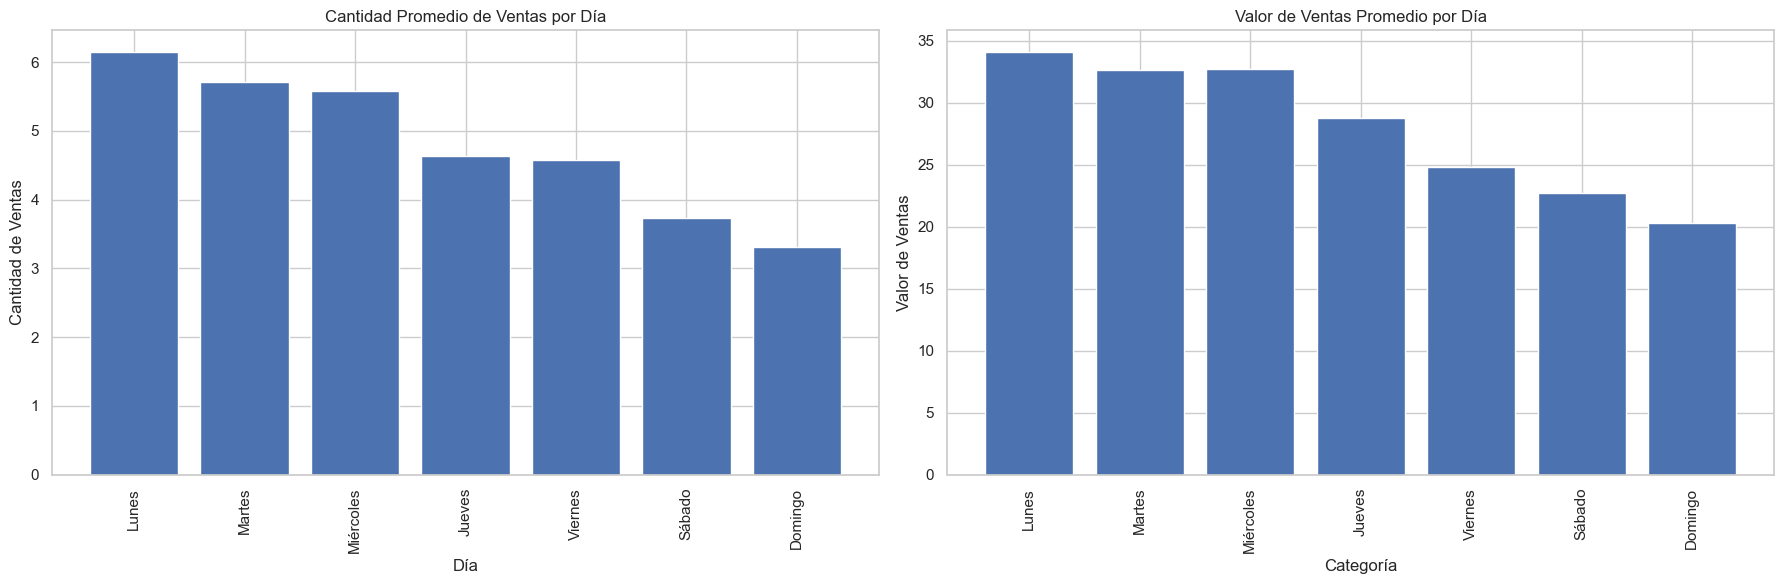

In [282]:
#GRAFICO DE CANTIDADES VENDIDAS
#Agrupamos la cantidad de ventas por dia de la semana
total_sales = df.groupby('day')['SOLD_QUANTITY'].sum()
offer_counts = df.groupby('day').size()
#Calculamos el promedio de ventas por día
avg_sales_by_day = (total_sales / offer_counts).reset_index(name='avg_sales_per_offer')
avg_sales_by_day['day'] = pd.Categorical(avg_sales_by_day['day'], categories=weekday_order, ordered=True)
avg_sales_by_day = avg_sales_by_day.sort_values('day')
avg_sales_by_day['day'] = avg_sales_by_day['day'].replace(weekday_trad)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

axes[0].bar(avg_sales_by_day['day'], avg_sales_by_day['avg_sales_per_offer'], width=0.8)
axes[0].set_xlabel('Día')
axes[0].set_ylabel('Cantidad de Ventas')
axes[0].set_title('Cantidad Promedio de Ventas por Día')
axes[0].tick_params(axis='x', rotation=90)

#GRAFICO DE VALORES VENDIDOS
#Agrupamos el valor de ventas por dia de la semana
total_sales = df.groupby('day')['SOLD_AMOUNT'].sum()
offer_counts = df.groupby('day').size()
#Calculamos el valor de ventas promedio por dia
avg_sales_by_day = (total_sales / offer_counts).reset_index(name='avg_sales_per_offer')
avg_sales_by_day['day'] = pd.Categorical(avg_sales_by_day['day'], categories=weekday_order, ordered=True)
avg_sales_by_day = avg_sales_by_day.sort_values('day')
avg_sales_by_day['day'] = avg_sales_by_day['day'].replace(weekday_trad)
axes[1].bar(avg_sales_by_day['day'], avg_sales_by_day['avg_sales_per_offer'], width=0.8)
axes[1].set_xlabel('Categoría')
axes[1].set_ylabel('Valor de Ventas')
axes[1].set_title('Valor de Ventas Promedio por Día')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


#### Ajustando por la cantidad de ofertas diarias, el comportamiento a lo largo de los días cambia sutilmente, ahora el día de mayor cantidad y valor de ventas es el lunes, pero la tendencia decreciente se mantiene, siendo el domingo el día de menores valores.

## <u>Ventas por categoría de productos</u>

### Artículos que más se vendieron

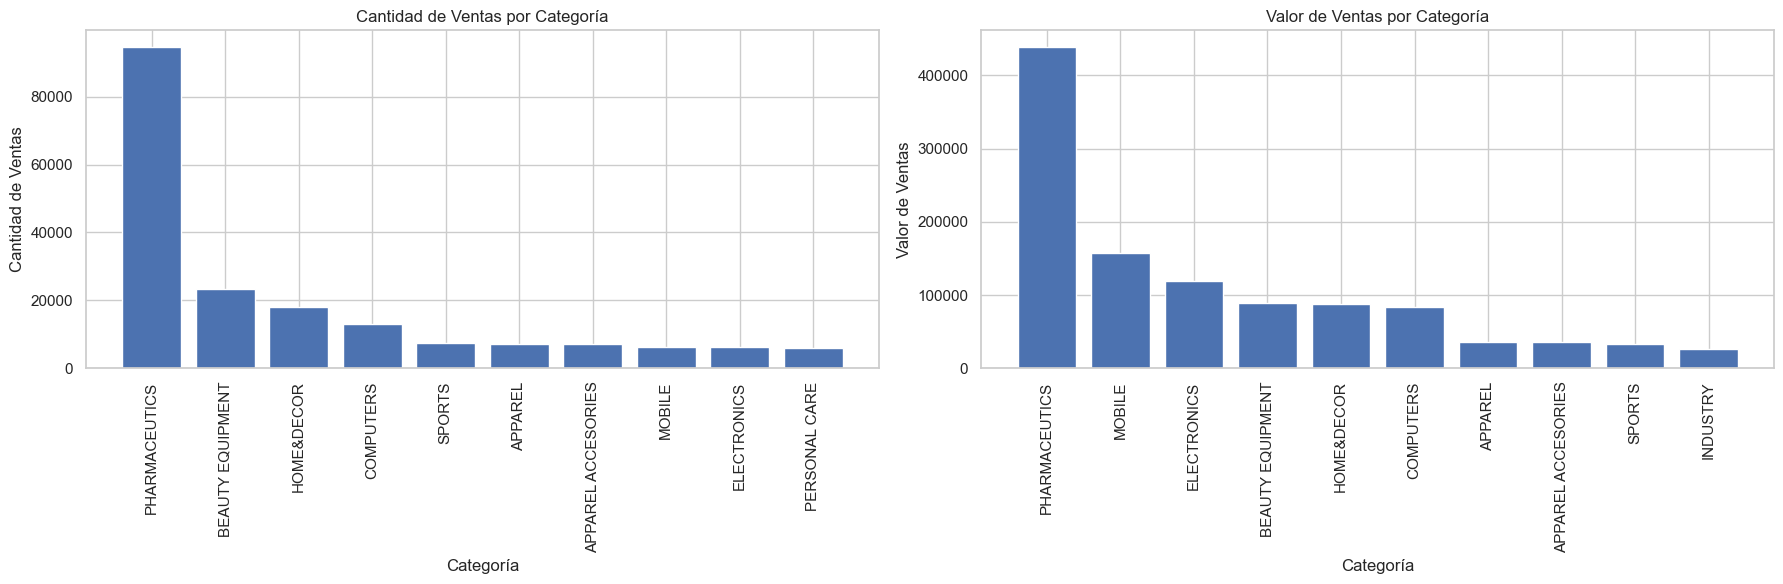

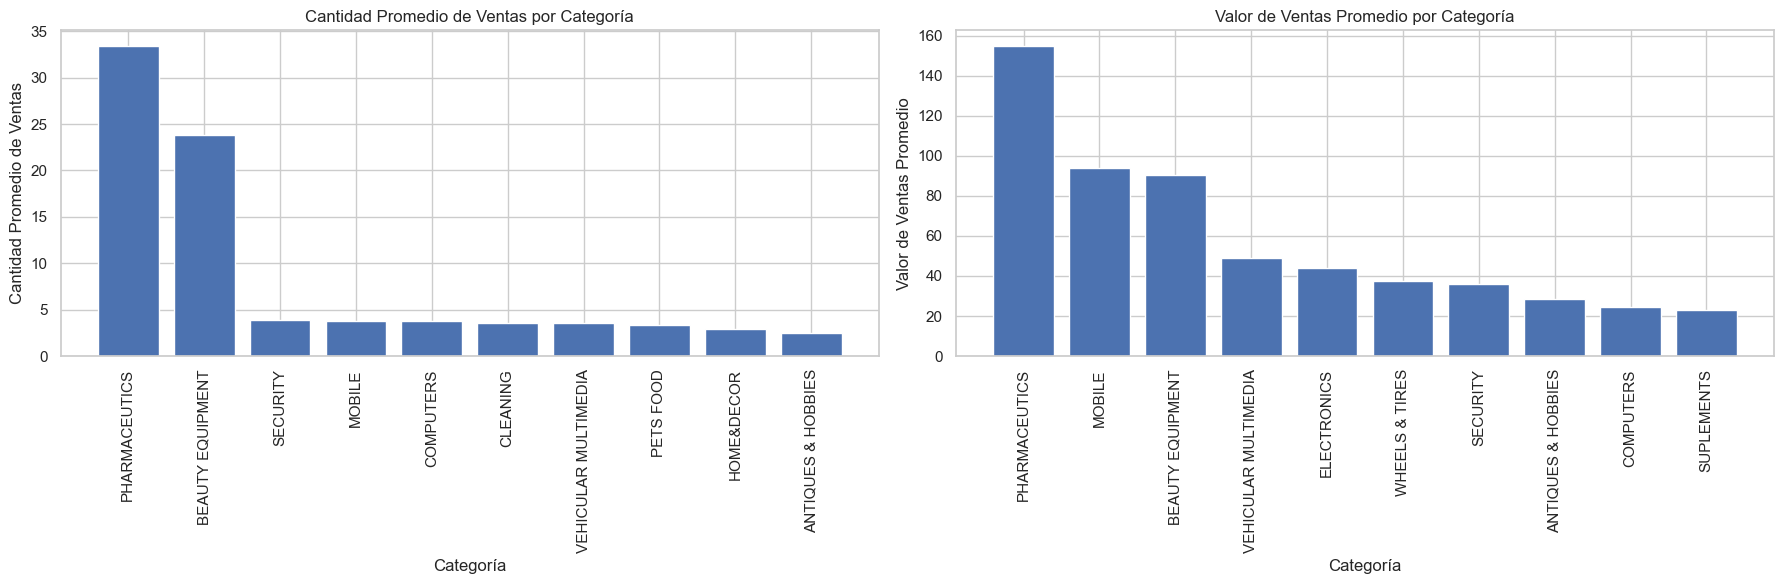

In [286]:
#Agrupamos las cantidades y valores vendidos por categoria
category_counts = df.groupby('DOM_DOMAIN_AGG1')[["SOLD_AMOUNT","SOLD_QUANTITY"]].sum().reset_index()
category_counts = category_counts.sort_values("SOLD_AMOUNT", ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns
#GRAFICO DE CANTIDADES
category_counts=category_counts.sort_values("SOLD_QUANTITY",ascending=False)
category_counts_top=category_counts[:10]
axes[0].bar(category_counts_top['DOM_DOMAIN_AGG1'], category_counts_top['SOLD_QUANTITY'], width=0.8)
axes[0].set_xlabel('Categoría')
axes[0].set_ylabel('Cantidad de Ventas')
axes[0].set_title('Cantidad de Ventas por Categoría')
axes[0].tick_params(axis='x', rotation=90)

#GRAFICO DE VALORES
category_counts=category_counts.sort_values("SOLD_AMOUNT",ascending=False)
category_counts_top=category_counts[:10]
axes[1].bar(category_counts_top['DOM_DOMAIN_AGG1'], category_counts_top['SOLD_AMOUNT'], width=0.8)
axes[1].set_xlabel('Categoría')
axes[1].set_ylabel('Valor de Ventas')
axes[1].set_title('Valor de Ventas por Categoría')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


#### GRAFICOS DE PROMEDIO


fig, axes = plt.subplots(1, 2, figsize=(18, 6))  

#GRAFICO DE CANTIDADES
#Agrupamos las cantidades vendidas por categoria y calculamos las cantidades vendidas promedio por categoria y nos quedamos con las diez mas grandes
category_counts = df.groupby('DOM_DOMAIN_AGG1')["SOLD_QUANTITY"].sum() / df.groupby('DOM_DOMAIN_AGG1').size()
category_counts = category_counts.reset_index(name='SOLD_QUANTITY')
category_counts=category_counts.sort_values("SOLD_QUANTITY",ascending=False)
category_counts_top=category_counts[:10]
axes[0].bar(category_counts_top['DOM_DOMAIN_AGG1'], category_counts_top['SOLD_QUANTITY'], width=0.8)
axes[0].set_xlabel('Categoría')
axes[0].set_ylabel('Cantidad Promedio de Ventas')
axes[0].set_title('Cantidad Promedio de Ventas por Categoría')
axes[0].tick_params(axis='x', rotation=90)

#GRAFICO DE VALORES
#Calculamos los valores vendidos promedio por categoria y nos quedamos con las diez mas grandes
category_counts = df.groupby('DOM_DOMAIN_AGG1')["SOLD_AMOUNT"].sum() / df.groupby('DOM_DOMAIN_AGG1').size()
category_counts = category_counts.reset_index(name='SOLD_AMOUNT')
category_counts=category_counts.sort_values("SOLD_AMOUNT",ascending=False)
category_counts_top=category_counts[:10]

axes[1].bar(category_counts_top['DOM_DOMAIN_AGG1'], category_counts_top['SOLD_AMOUNT'], width=0.8)
axes[1].set_xlabel('Categoría')
axes[1].set_ylabel('Valor de Ventas Promedio')
axes[1].set_title('Valor de Ventas Promedio por Categoría')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



In [296]:
print("Porcentaje de los valores de ventas totales que son de PHARMACEUTICS: ",df["SOLD_AMOUNT"][df.DOM_DOMAIN_AGG1=="PHARMACEUTICS"].sum()/df["SOLD_AMOUNT"].sum())

Porcentaje de las ventas totales que son de PHARMACEUTICS:  0.3502235177423299


In [298]:
print("Porcentaje de las cantidades de ventas totales que son de PHARMACEUTICS: ",df["SOLD_QUANTITY"][df.DOM_DOMAIN_AGG1=="PHARMACEUTICS"].sum()/df["SOLD_QUANTITY"].sum())

Porcentaje de las cantidades de ventas totales que son de PHARMACEUTICS:  0.4393234829132146


In [304]:
#Calculamos el precio promedio de cada categoría
df["avg_price"]=df["SOLD_AMOUNT"]/df["SOLD_QUANTITY"]
avg_price_per_category = df.groupby('DOM_DOMAIN_AGG1')[["avg_price"]].mean().reset_index()
print("Categorías con precios promedio mas altos:")
avg_price_per_category.sort_values("avg_price",ascending=False)[:10]

Categorías con precios promedio mas altos:


,DOM_DOMAIN_AGG1,avg_price
35,WHEELS & TIRES,34.843350
13,ELECTRONICS,23.022139
18,MOBILE,21.488470
2,ANTIQUES & HOBBIES,15.678333
34,VEHICULAR MULTIMEDIA,14.245247
20,MUSICAL INSTRUMENTS,13.349667
11,COMPUTERS,12.559552
17,INDUSTRY,11.218855
31,SUPLEMENTS,11.016832
28,SECURITY,10.941628


#### La categoría PHARMACEUTICS es claramente la que más se vendío a lo largo de este período, representando el 35% del valor de las ventas y 43% de la cantidad de ventas a pesar de no estar ni siquiera entre las 10 categorías con precio promedio más altos (de hecho es la número 17). De hecho podemos ver que las 10 categorías con precio promedio más alto se encuentran en alguno de los dos gráficos de valores de ventas. A continuación analizaremos más en detalle la categoría PHARMACEUTICS para ver que productos fueron los que más se vendieron.

## <u> Análisis de la categoría con más ventas</u>

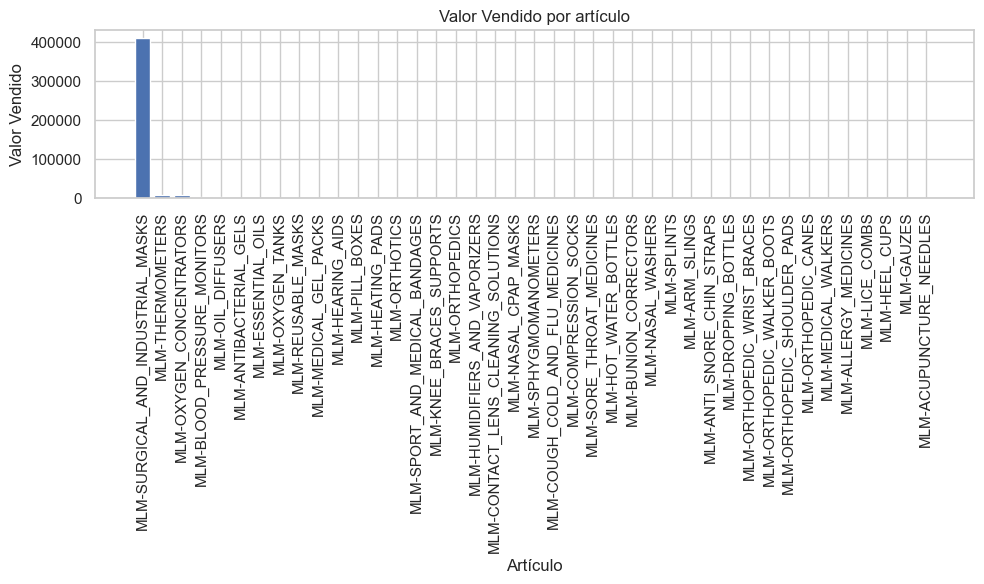

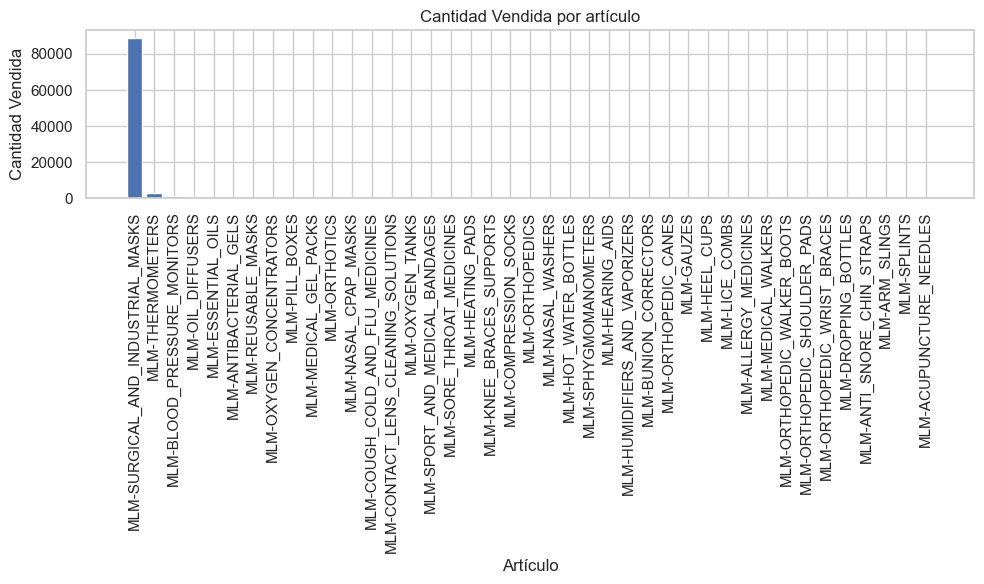

In [311]:
#Agrupamos las cantidades y valores vendidos por artículo.
df_pharma=df[df.DOM_DOMAIN_AGG1=="PHARMACEUTICS"]
category_counts = df_pharma.groupby('DOMAIN_ID')[['SOLD_AMOUNT',"SOLD_QUANTITY"]].sum().reset_index()
category_counts=category_counts.sort_values("SOLD_AMOUNT",ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(category_counts['DOMAIN_ID'], category_counts['SOLD_AMOUNT'], width=0.8)  # bar plot
plt.xlabel('Artículo')
plt.ylabel('Valor Vendido')
plt.title('Valor Vendido por artículo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

category_counts=category_counts.sort_values("SOLD_QUANTITY",ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(category_counts['DOMAIN_ID'], category_counts['SOLD_QUANTITY'], width=0.8)  # bar plot
plt.xlabel('Artículo')
plt.ylabel('Cantidad Vendida')
plt.title('Cantidad Vendida por artículo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [315]:
#Porcentaje de las ventas totales de la categoría PHARMACEUTICS que representan las mascaras quirugicas
print(df["SOLD_AMOUNT"][df.DOMAIN_ID=="MLM-SURGICAL_AND_INDUSTRIAL_MASKS"].sum()/df["SOLD_AMOUNT"][df.DOM_DOMAIN_AGG1=="PHARMACEUTICS"].sum())
print(df["SOLD_QUANTITY"][df.DOMAIN_ID=="MLM-SURGICAL_AND_INDUSTRIAL_MASKS"].sum()/df["SOLD_QUANTITY"][df.DOM_DOMAIN_AGG1=="PHARMACEUTICS"].sum())

0.9326225082500182
0.9351723846811385


#### El artículo MLM-SURGICAL_AND_INDUSTRIAL_MASKS representa casi la totalidad (93%) de las cantidades/valores vendidos de la categoría Pharmaceutics. Esto tiene sentido para la época del dataset debido a la pandemia.

## <u>Análisis de cantidad de ventas en relación al stock inicial</u>

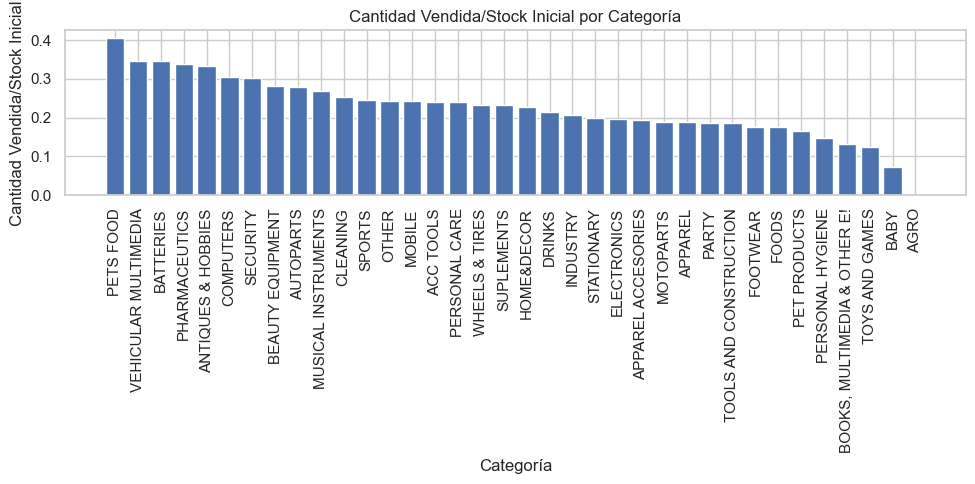

In [319]:
#Creamos la variable para analizar la cantidad vendida sobre el stock inicial
df["cantidad_vendida_sobre_stock"]=df.SOLD_QUANTITY/df.INVOLVED_STOCK

category_counts = df.groupby('DOM_DOMAIN_AGG1')[['cantidad_vendida_sobre_stock']].mean().reset_index()
category_counts=category_counts.sort_values("cantidad_vendida_sobre_stock",ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(category_counts['DOM_DOMAIN_AGG1'], category_counts['cantidad_vendida_sobre_stock'], width=0.8)  # bar plot
plt.xlabel('Categoría')
plt.ylabel('Cantidad Vendida/Stock Inicial')
plt.title('Cantidad Vendida/Stock Inicial por Categoría')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#### La categoría que más ventas tuvo en relación al stock inicial fue la de PETS FOOD (~40%) seguida por VEHICULAR_MULTIMEDIA (~35%)

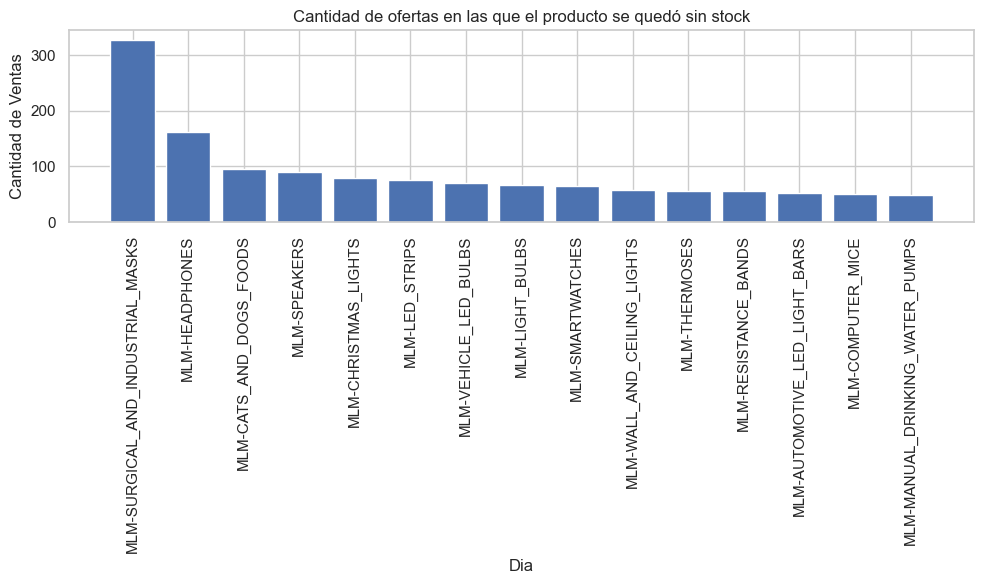

In [322]:
#Extraemos las ofertas en las que el stock termino siendo 0 o negativo
df_no_stock=df[df["REMAINING_STOCK_AFTER_END"]<1]
#Contamos la cantidad de veces que cada producto se quedo sin stock
df_no_stock_grouped = df_no_stock.groupby('DOMAIN_ID').size().reset_index(name='count')
df_no_stock_grouped = df_no_stock_grouped.sort_values('count',ascending=False)
#Elegimos los 15 productos que mas veces se quedaron sin stock
df_no_stock_grouped_top=df_no_stock_grouped[:15]
plt.figure(figsize=(10, 6))
plt.bar(df_no_stock_grouped_top['DOMAIN_ID'], df_no_stock_grouped_top['count'], width=0.8)  # bar plot
plt.xlabel('Dia')
plt.ylabel('Cantidad de Ventas')
plt.title('Cantidad de ofertas en las que el producto se quedó sin stock')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Esto da una idea de en que categorías se podrían realizar análisis más detallados para ajustar las cantidades de stock para próximas ofertas.

## <u> Resultados más relevantes </u>

- El promedio de ventas diarias se incrementó a lo largo del período analizado.
- En promedio, las ofertas que empezaron los lunes tuvieron mayores ventas que las que empezaron el resto de los días.
- En promedio, las ofertas que empezaron cerca de mediados de mes tuvieron mayores ventas comparadas a otros días.
- Las ofertas que empezaron a las 22hs y duraron sólo una hora fueron las que en promedio vendieron más.
- La categoría PHARMACEUTICS fue considerablemente la de mayores ventas debido seguramente a la pandemia y a la compra de barbijos.
- La categoría PETS_FOOD fue la que vendió la mayor parte de su stock inicial.